In [77]:
import time
# Obróbka danych
import pandas as pd
import numpy as np

# Wizualizacja 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mgno 

# Przygotowanie danych 
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt import Trials
from sklearn.model_selection import cross_validate,train_test_split,cross_val_score,KFold 
from sklearn.feature_selection import SelectPercentile, chi2
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer,make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline,FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, Normalizer, OrdinalEncoder, OneHotEncoder
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix,accuracy_score,make_scorer,precision_score,recall_score,f1_score,classification_report

# Modele
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import catboost as catb
import lightgbm as lgbm
import xgboost as xgb
from xgboost import plot_importance

#Ziarno losowe
random_state=123
np.random.seed(42)

#Tworzenie logów
import logging

# Wyświetlanie notebooka
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Wizualizacje wykresów
fontdict = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }
from warnings import filterwarnings
filterwarnings('ignore')

In [33]:
def log(path, file):
    """[Create a log file to record the experiment's logs]
    
    Arguments:
        path {string} -- path to the directory
        file {string} -- file name
    
    Returns:
        [func] -- [logger that record logs]
    """

    log_file = os.path.join(path, file)

    if not os.path.isfile(log_file):
        open(log_file, "w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    logging.basicConfig(level=logging.INFO, format=console_logging_format)
    logger = logging.getLogger()
    
    handler = logging.FileHandler(log_file)

    handler.setLevel(logging.INFO)
    
    formatter = logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)

    logger.addHandler(handler)

    return logger

In [34]:
df = pd.read_csv("./waterQuality1.csv")
df.sample(10)

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
4017,0.03,26.82,0.00,0.06,0.080,0.03,0.08,0.02,0.99,0.00,...,0.071,0.31,0.04,0.002,12.15,0.82,0.00,0.04,0.05,0
2577,0.27,26.73,0.04,0.27,0.007,0.78,0.90,1.86,0.26,0.55,...,0.013,1.74,1.24,0.008,11.52,1.34,0.03,0.19,0.05,0
3693,0.21,3.34,0.16,2.65,0.100,5.35,0.37,0.07,1.45,0.49,...,0.001,14.23,1.86,0.001,27.66,2.07,0.04,0.50,0.09,0
6574,0.01,26.45,0.07,1.27,0.080,0.06,0.08,1.71,0.80,0.13,...,0.176,16.11,1.19,0.006,0.27,0.12,0.01,0.00,0.01,0
7566,0.07,13.52,0.04,0.23,0.040,0.08,0.02,1.82,0.56,0.00,...,0.154,17.56,2.00,0.004,2.30,0.77,0.07,0.02,0.05,0
3801,0.05,26.2,0.81,1.30,0.110,1.05,0.53,0.05,0.88,0.93,...,0.076,15.42,1.08,0.009,52.77,6.60,0.05,0.34,0.05,0
6281,0.07,7,0.04,0.18,0.030,0.04,0.06,1.86,0.42,0.15,...,0.115,5.58,1.97,0.005,3.17,0.52,0.06,0.01,0.06,0
1123,2.52,25.1,0.05,1.27,0.040,2.84,0.04,0.87,0.16,0.00,...,0.043,7.61,1.60,0.008,15.93,5.99,0.02,0.40,0.05,0
4047,0.05,8.68,0.03,0.40,0.080,0.10,0.03,0.05,0.14,0.00,...,0.069,8.43,0.15,0.007,2.63,1.03,0.08,0.05,0.09,0
6818,0.06,28.27,0.07,2.91,0.020,0.26,0.10,1.50,0.48,0.65,...,0.125,14.07,1.67,0.000,1.63,2.76,0.06,0.08,0.06,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [36]:
df[df['ammonia'] == '#NUM!']

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
7551,0.03,#NUM!,0.08,0.79,0.07,0.08,0.05,0.58,0.34,0.00,...,0.183,4.37,1.43,0.007,0.62,2.54,0.07,0.05,0.05,#NUM!
7568,0.06,#NUM!,0.07,1.72,0.08,0.32,0.01,1.11,0.61,0.00,...,0.178,12.10,2.03,0.008,1.37,2.05,0.06,0.10,0.07,#NUM!
7890,0.01,#NUM!,0.08,0.49,0.00,0.07,0.09,0.06,0.72,0.57,...,0.088,9.57,1.45,0.009,7.67,7.70,0.03,0.05,0.02,#NUM!


In [37]:
df=df[df['ammonia'] != '#NUM!']
df.shape

(7996, 21)

In [38]:
df['ammonia'] = df['ammonia'].astype(float)
df['is_safe'] = df['is_safe'].astype(float)

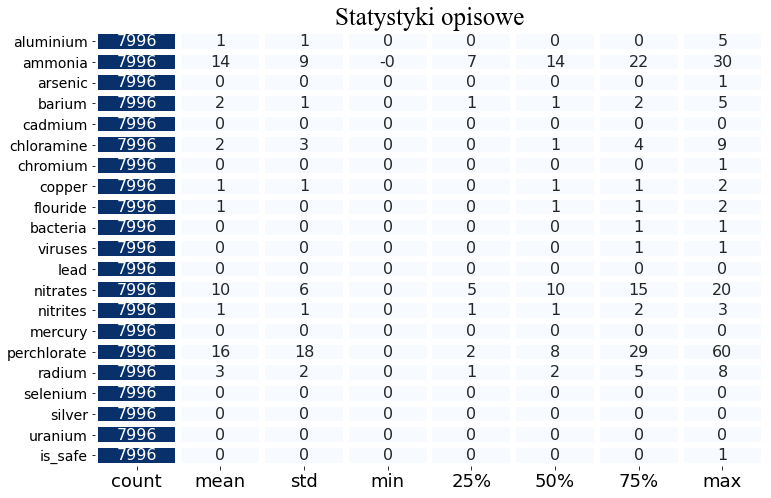

In [39]:
desc = df.describe().T
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(desc,annot=True,cmap = "Blues", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 16})
plt.xticks(size = 18)
plt.yticks(size = 14, rotation = 0)
plt.title("Statystyki opisowe", fontdict=fontdict)
plt.show()

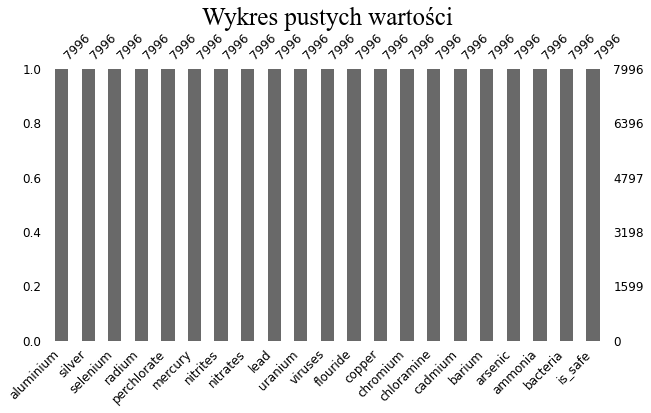

In [40]:
mgno.bar(df, figsize=(10,5), fontsize=12,sort="ascending");
plt.title('Wykres pustych wartości',fontdict=fontdict)
plt.show()

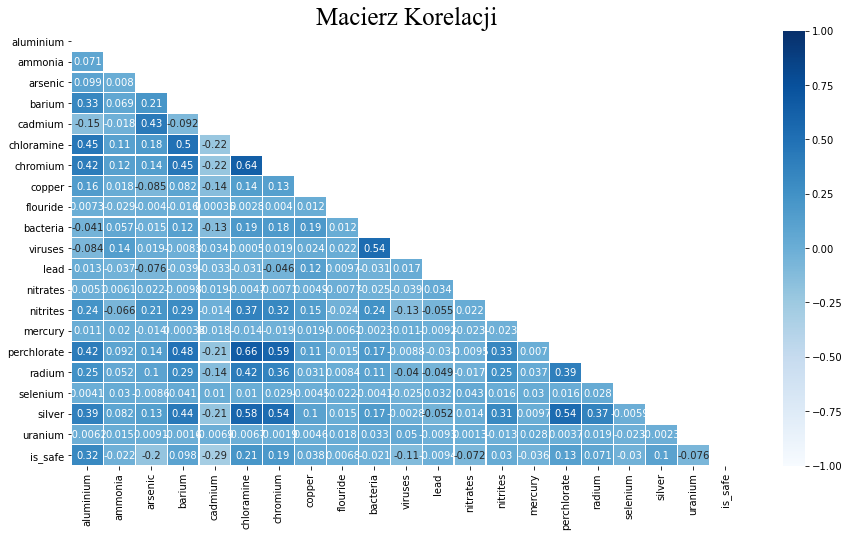

In [41]:
plt.figure(figsize=(15,8))
corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,linewidths=0.2,vmin=-1,vmax=1,mask=mask, cmap='Blues',center=0,cbar_kws={'alpha':0.1})
plt.title('Macierz Korelacji',fontdict=fontdict)
plt.show()

In [42]:
cols = df.columns[:-1]
for col in cols:
    print("{} = {}".format(col,df[col].skew()))

aluminium = 2.0134627045986115
ammonia = 0.026804485284098088
arsenic = 1.9852414162523806
barium = 0.6609568467500901
cadmium = 0.4782263714938959
chloramine = 0.888122552573934
chromium = 1.0281875935048819
copper = 0.25355804997424575
flouride = -0.039733321559774694
bacteria = 0.5544174786607943
viruses = 0.4245668331619121
lead = -0.060600898324101045
nitrates = -0.04205984794520487
nitrites = -0.49821155027632374
mercury = -0.08172613642495993
perchlorate = 0.9377671483069505
radium = 0.548390578720597
selenium = 0.010494764277532776
silver = 1.0294889184168248
uranium = -0.02703998376636728


In [43]:
cols = df.columns[:-1]
threshold = 0.2

for col in cols:
    if df[col].skew() > threshold:
        df[col] = np.log1p(df[col]) #np.log1p
    else:
        pass

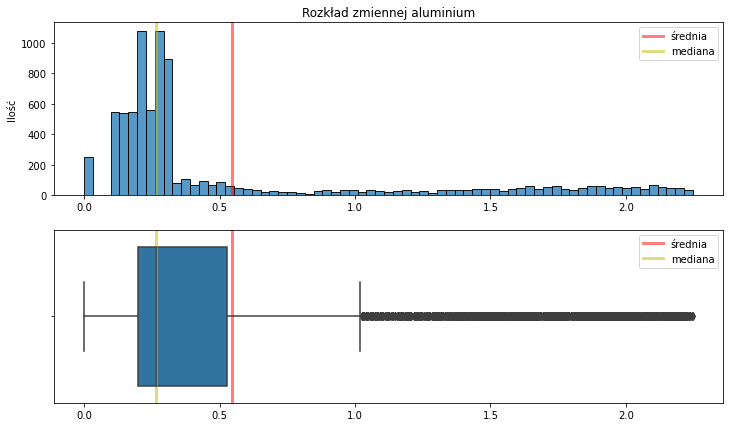

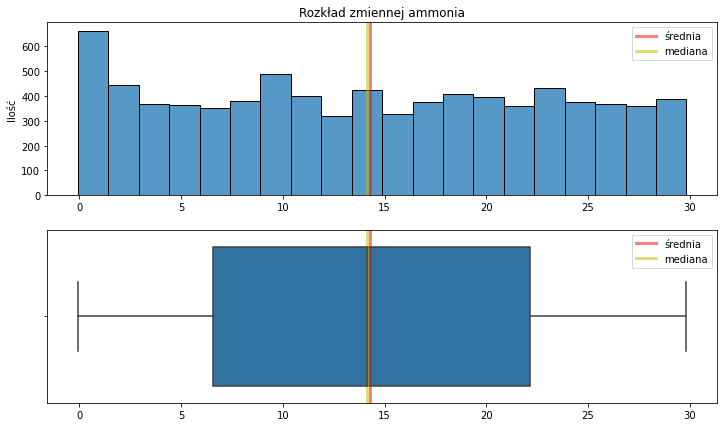

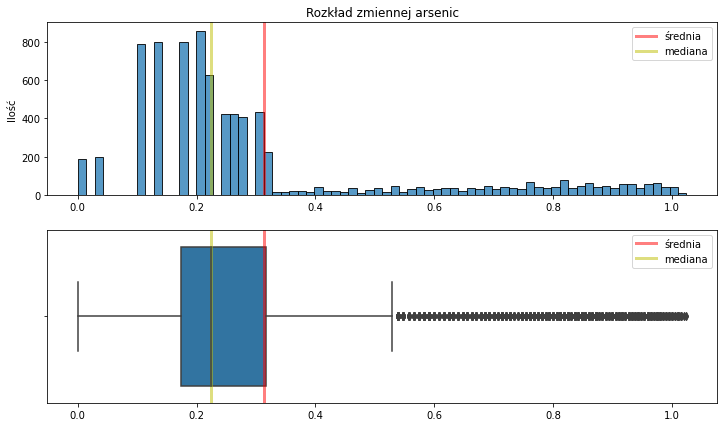

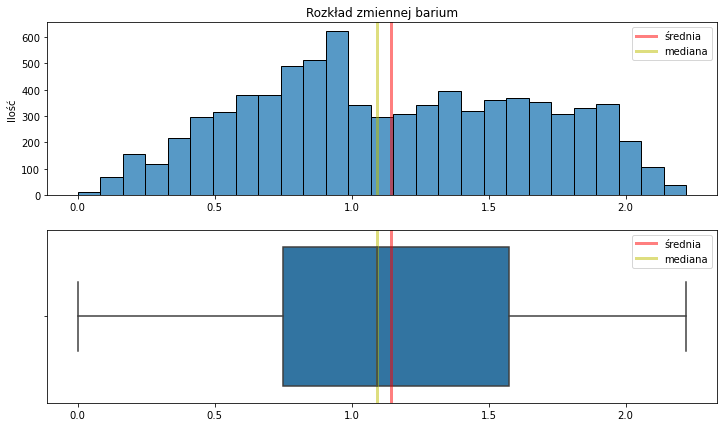

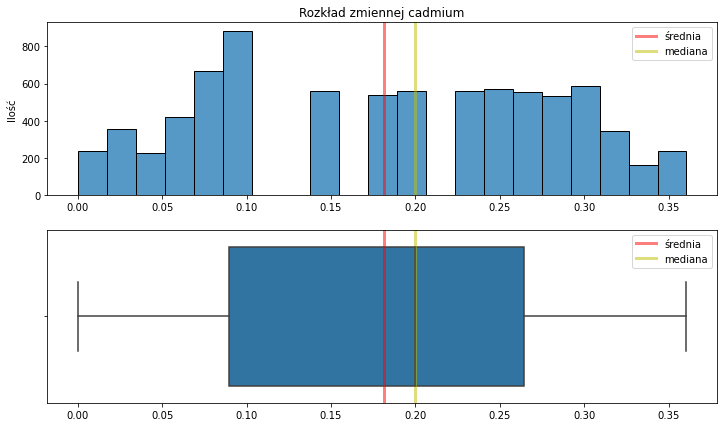

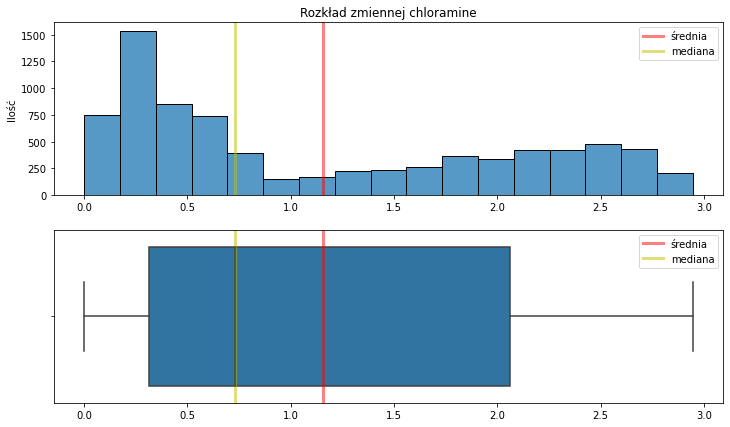

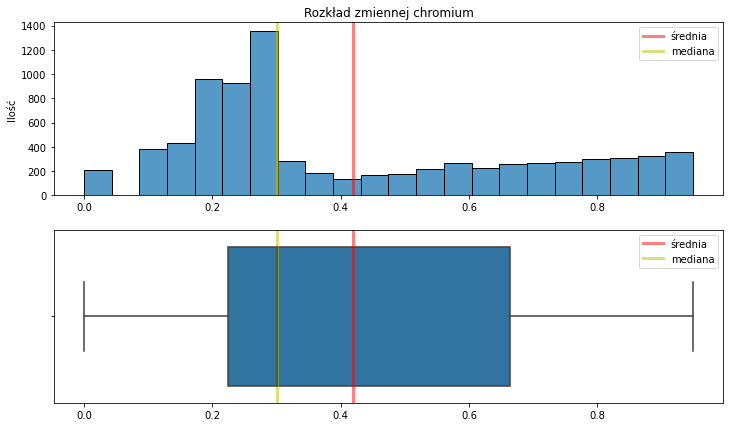

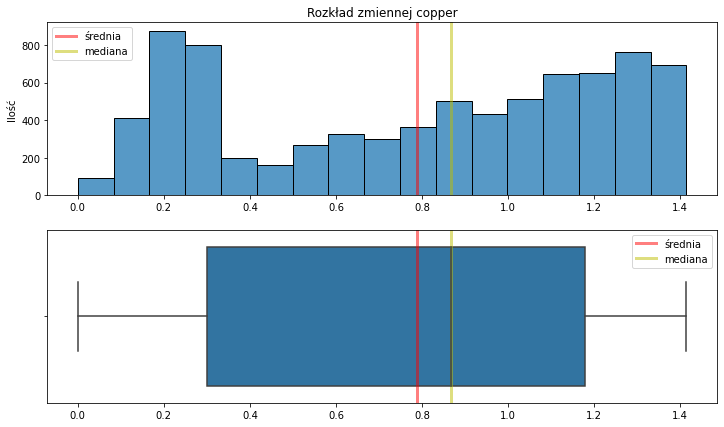

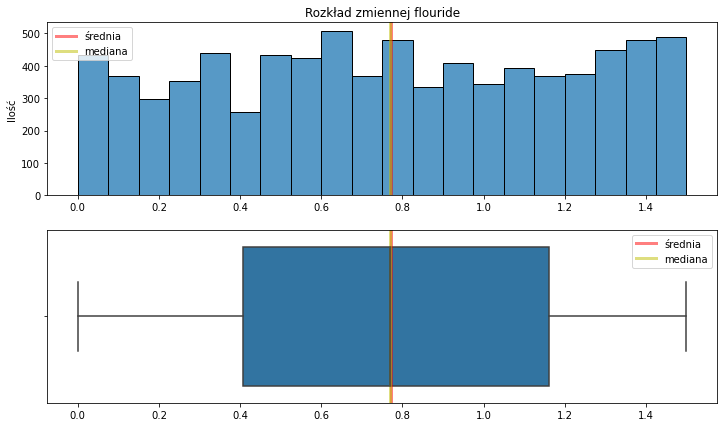

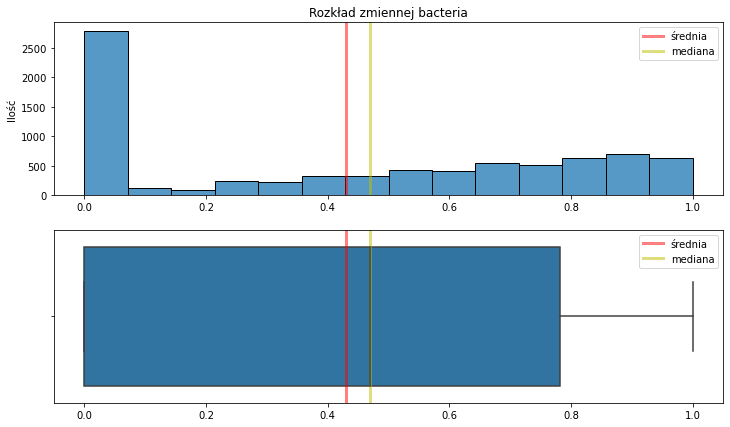

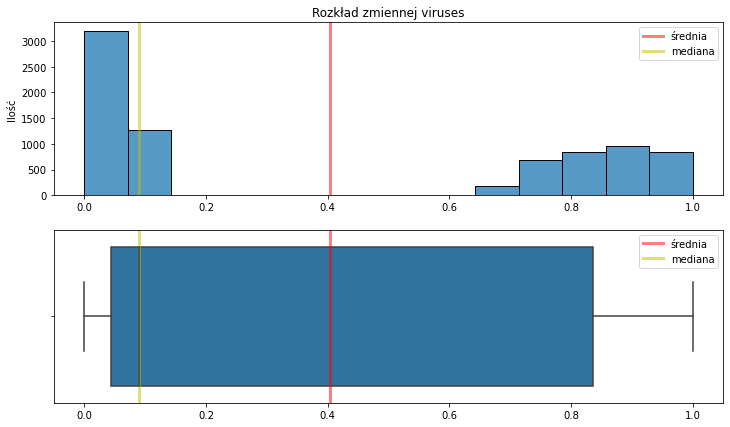

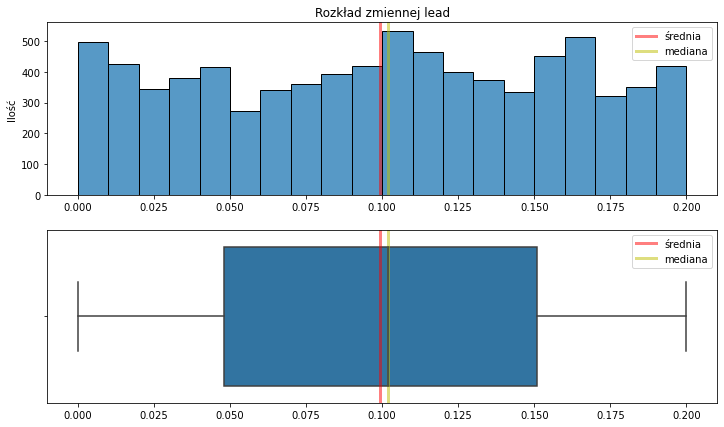

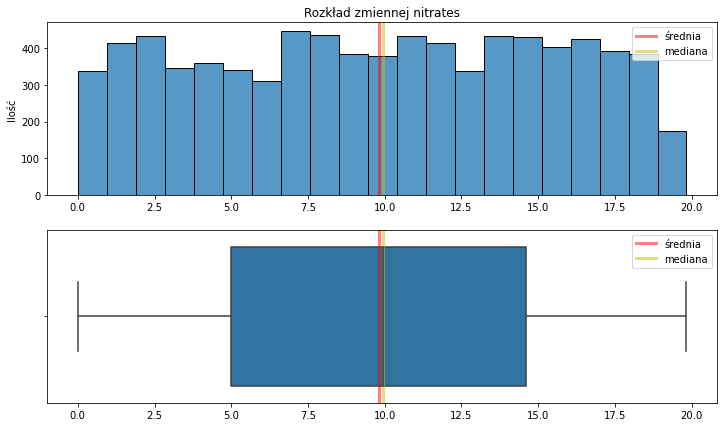

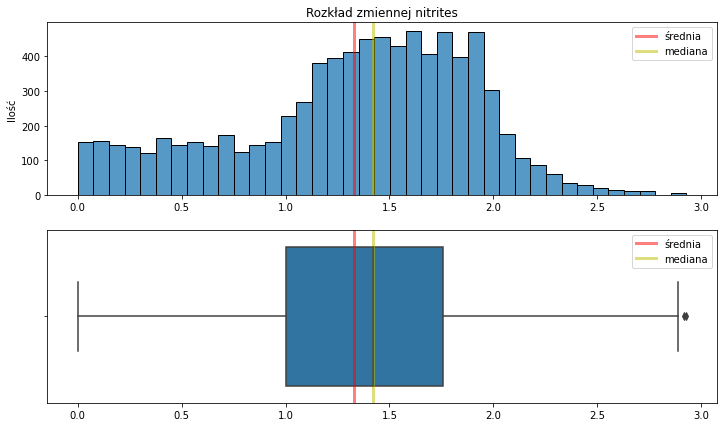

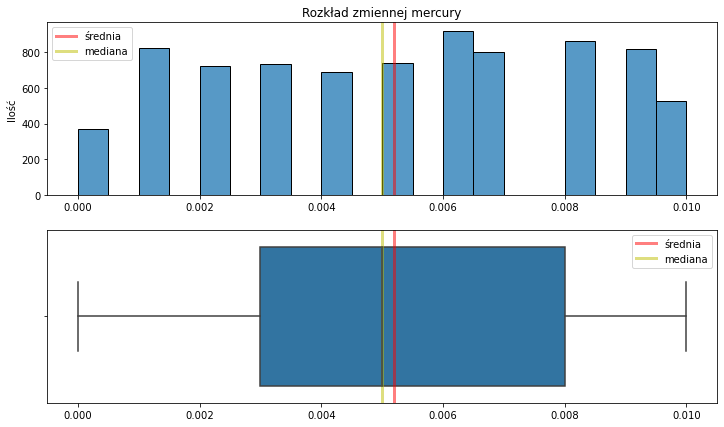

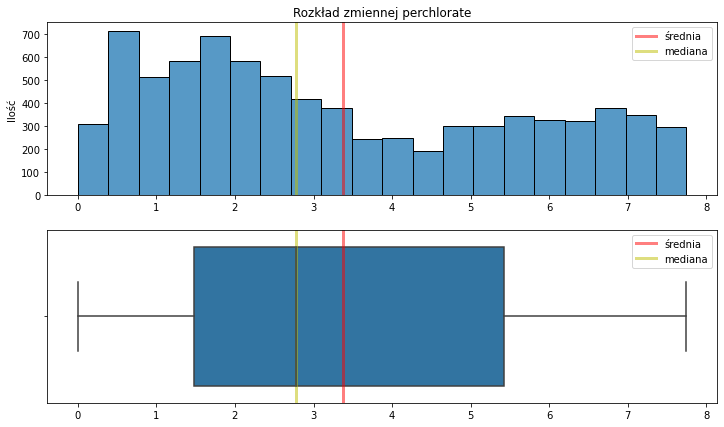

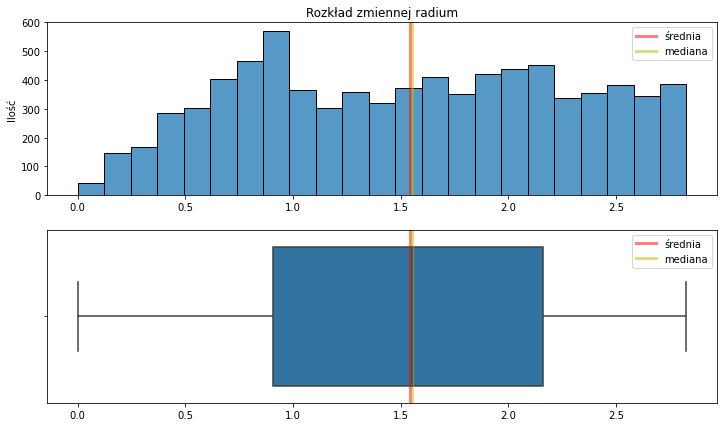

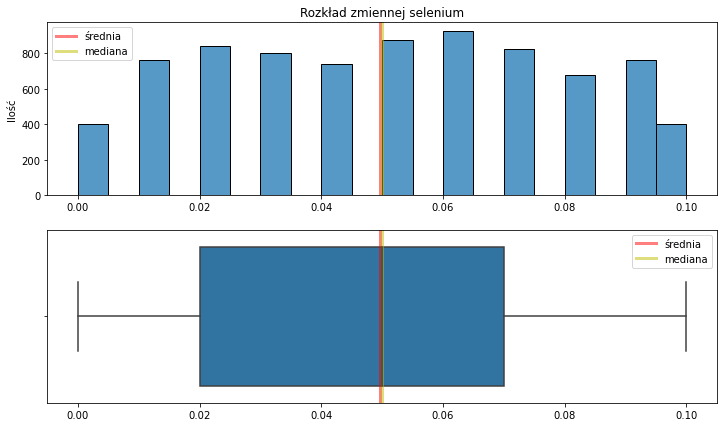

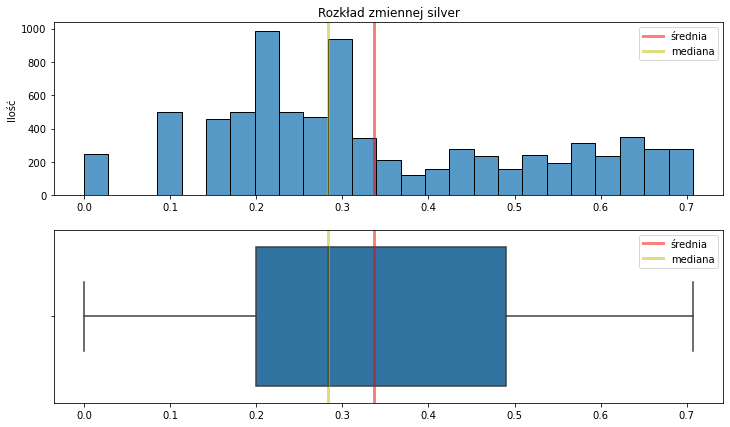

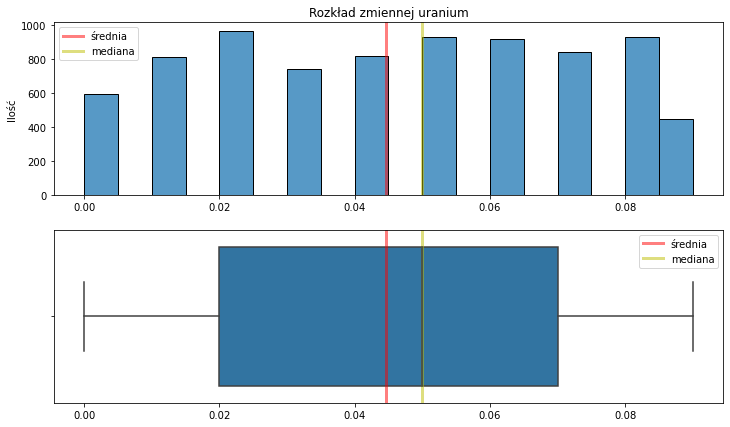

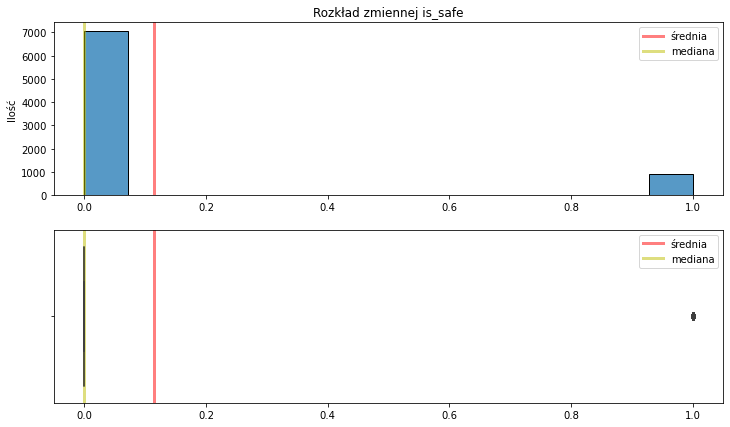

In [44]:
cols = df.columns
for col in cols:
    fig, axes = plt.subplots(2, 1,figsize=(12, 7))
    
    axes[0].axvline(x=df[col].mean(), linewidth=3, color='r', label="mean", alpha=0.5,)
    axes[0].axvline(x=df[col].median(), linewidth=3, color='y', label="median", alpha=0.5,)
    sns.histplot(df[col],ax=axes[0])
    
    axes[1].axvline(x=df[col].mean(), linewidth=3, color='r', label="mean", alpha=0.5,)
    axes[1].axvline(x=df[col].median(), linewidth=3, color='y', label="median", alpha=0.5,)
    sns.boxplot(x=df[col],ax=axes[1])

    axes[0].set_ylabel('Ilość')
    axes[0].set_xlabel('')
    axes[0].set_title("Rozkład zmiennej {}".format(col))
    axes[0].legend(["średnia", "mediana"])
    axes[1].legend(["średnia", "mediana"])
    axes[1].set_xlabel('')

In [45]:
cols = df.columns
for col in cols:
    print("{} = {}".format(col,df[col].skew()))

aluminium = 1.5549879309570278
ammonia = 0.026804485284098088
arsenic = 1.3973633123221563
barium = 0.059967249300076346
cadmium = -0.09687070883650266
chloramine = 0.45506503853747743
chromium = 0.5610274979703058
copper = -0.21435557389556276
flouride = -0.039733321559774694
bacteria = 0.015728478993468915
viruses = 0.2787310457989292
lead = -0.060600898324101045
nitrates = -0.04205984794520487
nitrites = -0.49821155027632374
mercury = -0.08172613642495993
perchlorate = 0.3924127565013321
radium = -0.0191913969814247
selenium = 0.010494764277532776
silver = 0.43617996975000156
uranium = -0.02703998376636728
is_safe = 2.428682283648684


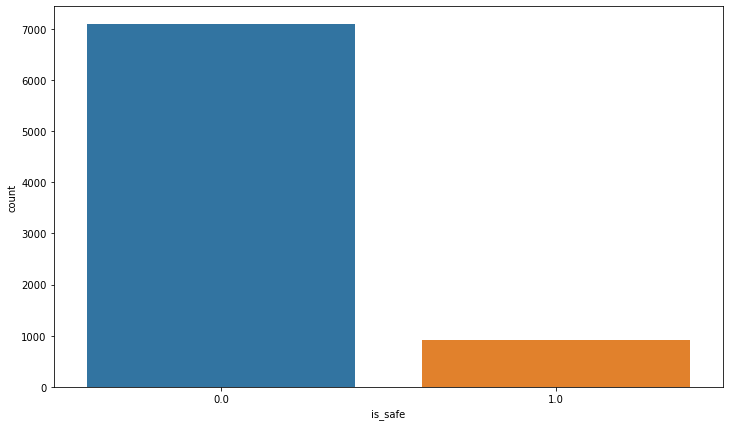

In [67]:
fig = plt.subplots(figsize=(12, 7))
ax.set_title("Ilość próbki is_safe")
sns.countplot(x ='is_safe', data = df);

In [47]:
X  = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state,shuffle=True,stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(5597, 20) (5597,)
(2399, 20) (2399,)


[16:11:02] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Importances :  [0.05786129 0.02236335 0.01949454 0.00993793 0.3667485  0.07476877
 0.0108351  0.0194368  0.0047689  0.04182654 0.07609886 0.01668385
 0.02931876 0.03480026 0.01092999 0.02589035 0.01848772 0.0219691
 0.06041859 0.07736082]


<Figure size 1080x576 with 0 Axes>

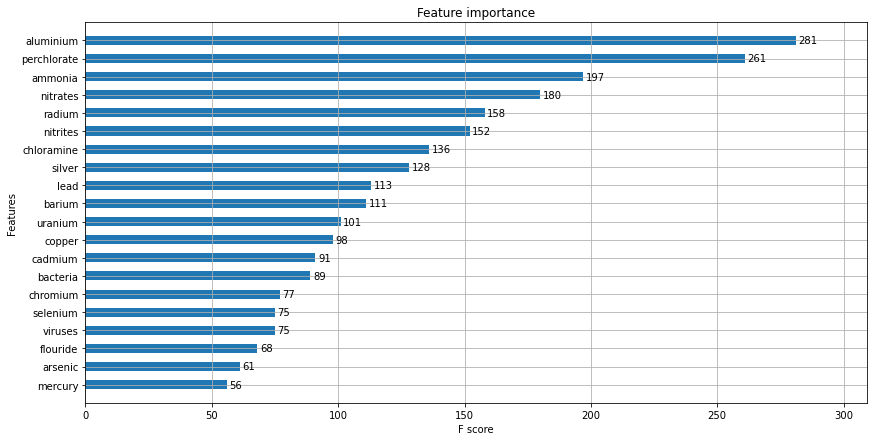

In [76]:
from xgboost import plot_importance

xgb_model = xgb.XGBClassifier(random_state = 0 )
xgb_model.fit(X_train, y_train)
plt.rcParams["figure.figsize"] = (14, 7)
print("Feature Importances : ", xgb_model.feature_importances_)

plot_importance(xgb_model,height=0.5,)
plt.show();

(9918, 20) (9918,)


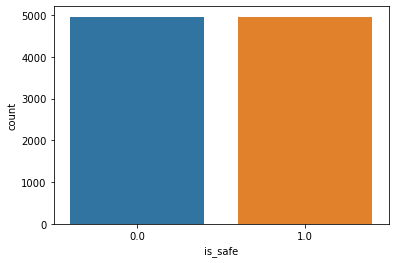

In [49]:
#Oversampling
over_sampler = RandomOverSampler(random_state=random_state)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
print(X_train.shape,y_train.shape)
full = X_train.copy()
full["is_safe"] = y_train
sns.countplot(x ='is_safe', data = full);

In [50]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

In [51]:
numerical_pipeline = Pipeline([
    ('numerical_imputer', KNNImputer(missing_values=np.nan, n_neighbors=3)),
    ('numerical_transformer', StandardScaler()),
])

In [52]:
data_processing_pipeline = ColumnTransformer([
    ("numerical_preprocessor", numerical_pipeline, numerical_columns)
])

data_processing_pipeline.fit_transform(X_train)

array([[ 0.11804733,  1.4012216 ,  0.70378492, ..., -1.00214854,
        -0.86780967,  0.67148726],
       [-0.72682476, -0.43417054, -0.74879713, ..., -0.29982313,
        -0.52347562,  1.41080904],
       [ 1.67401132, -0.77253892,  1.02385584, ...,  1.8071531 ,
         1.35278127, -0.80715631],
       ...,
       [-0.90536724,  0.27446628, -0.12195398, ...,  1.10482769,
        -0.74193111, -0.43749542],
       [ 1.78760663, -1.55181156, -0.43221605, ..., -0.65098583,
         0.67801348,  1.41080904],
       [ 0.94879097, -0.43075267, -0.74879713, ...,  0.40250228,
         1.26511077, -0.06783453]])

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
classifiers = [
        {
        'name': 'BaggingClassifier()',
        'class': BaggingClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'random_state' : 42
           }
    },
    {
        'name': 'RandomForestClassifier()',
        'class': RandomForestClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'min_samples_leaf':hp.uniformint('min_samples_leaf', 1, 5),
            'min_samples_split':hp.uniformint('min_samples_split', 2, 10),
            'bootstrap': hp.choice('bootstrap', [True,  False]),
            'max_features': hp.choice('max_features', ['auto', 'sqrt']),
            'random_state' : 42
           }
    },
     {
        'name': 'GradientBoostingClassifier()',
        'class': GradientBoostingClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'random_state' : 42
           }
    },
    {
        'name': 'XGBClassifier()',
        'class': xgb.XGBClassifier(eval_metric = "mlogloss"),
        'max_evals': 100,
        'eval_metric': "mlogloss",
        'params' : {
            'learning_rate': hp.loguniform ('learning_rate', 0.01, 0.5),
            'max_depth': hp.choice('max_depth', np.arange(2, 11).tolist()),
            'min_child_weight': hp.choice('min_child_weight', np.arange(0, 101).tolist()),
            'gamma': hp.loguniform('gamma', 0.0, 2.0),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', 0.0, 2.0),
            'reg_lambda': hp.loguniform('reg_lambda', 0.0, 2.0),
            'random_state' : 42
        }
    },    
]

In [54]:
import os
logger = log(path="./logs/", file="score.logs")

In [55]:
def objective(space):
    pipe_params = {}
    
    for s in space:
        pipe_params[f"classifier__{s}"] = space[s]
        
    pipe.set_params(**pipe_params)
    
    score = cross_val_score(pipe, X_train, y_train, cv=10, scoring='roc_auc',n_jobs=-1).mean()
    
    return {'loss': 1- score, 'status': STATUS_OK, 'accuracy': score}

In [56]:
trials_df = []
 
for cl in classifiers:
    cl_name = cl['class'].__class__.__name__
    print(f"\n\n{cl_name}")
    
    pipe = Pipeline(steps = [
    ('data_processing_pipeline', data_processing_pipeline),
    ('classifier', cl['class'])
    ])
    
    space = {}
    for k in cl['params']:
        space[k] = cl['params'][k]
    
    max_evals = cl['max_evals']
    
    trials = Trials()
    best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
     
    best_params = space_eval(space, best)
    print('\nThe best params:')
    print ("{:<30} {}".format('Parameter','Selected'))
    for k, v in best_params.items():
        print ("{:<30} {}".format(k, v))
    
    for trial in trials.trials:
        trials_df.append({
            'classifier': cl_name,
            'loss': trial['result']['loss'],
            'accuracy': trial['result']['accuracy'],
            'params': trial['misc']['vals']
            })



BaggingClassifier
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 0 trials


  1%|▍                                           | 1/100 [00:19<31:33, 19.13s/trial, best loss: 2.5828573849806524e-05]

INFO build_posterior_wrapper took 0.001942 seconds
INFO TPE using 1/1 trials with best loss 0.000026


  2%|▉                                           | 2/100 [01:05<44:33, 27.28s/trial, best loss: 2.5828573849806524e-05]

INFO build_posterior_wrapper took 0.001988 seconds
INFO TPE using 2/2 trials with best loss 0.000026


  3%|█▎                                           | 3/100 [01:19<37:37, 23.27s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.002013 seconds
INFO TPE using 3/3 trials with best loss 0.000026


  4%|█▊                                           | 4/100 [01:41<36:42, 22.94s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.001987 seconds
INFO TPE using 4/4 trials with best loss 0.000026


  5%|██▎                                          | 5/100 [02:02<35:21, 22.33s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.001041 seconds
INFO TPE using 5/5 trials with best loss 0.000026


  6%|██▋                                          | 6/100 [02:38<41:36, 26.56s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000947 seconds
INFO TPE using 6/6 trials with best loss 0.000026


  7%|███▏                                         | 7/100 [03:02<39:44, 25.64s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.001024 seconds
INFO TPE using 7/7 trials with best loss 0.000026


  8%|███▌                                         | 8/100 [03:19<35:35, 23.21s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 8/8 trials with best loss 0.000026


  9%|████                                         | 9/100 [03:33<30:51, 20.35s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.001042 seconds
INFO TPE using 9/9 trials with best loss 0.000026


 10%|████▍                                       | 10/100 [03:59<33:01, 22.01s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.002995 seconds
INFO TPE using 10/10 trials with best loss 0.000026


 11%|████▊                                       | 11/100 [04:24<33:59, 22.91s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 11/11 trials with best loss 0.000026


 12%|█████▎                                      | 12/100 [04:46<33:01, 22.52s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 12/12 trials with best loss 0.000026


 13%|█████▋                                      | 13/100 [05:03<30:14, 20.86s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 13/13 trials with best loss 0.000026


 14%|██████▏                                     | 14/100 [05:49<40:56, 28.56s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000995 seconds
INFO TPE using 14/14 trials with best loss 0.000026


 15%|██████▌                                     | 15/100 [06:38<49:04, 34.64s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 15/15 trials with best loss 0.000026


 16%|███████                                     | 16/100 [07:01<43:40, 31.20s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000960 seconds
INFO TPE using 16/16 trials with best loss 0.000026


 17%|███████▍                                    | 17/100 [07:32<43:02, 31.11s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.001047 seconds
INFO TPE using 17/17 trials with best loss 0.000026


 18%|███████▉                                    | 18/100 [07:57<40:04, 29.32s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 18/18 trials with best loss 0.000026


 19%|████████▎                                   | 19/100 [08:29<40:28, 29.98s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 19/19 trials with best loss 0.000026


 20%|████████▊                                   | 20/100 [08:41<32:53, 24.67s/trial, best loss: 2.562246095183518e-05]

INFO build_posterior_wrapper took 0.001993 seconds
INFO TPE using 20/20 trials with best loss 0.000026


 21%|█████████                                  | 21/100 [08:56<28:42, 21.81s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 21/21 trials with best loss 0.000025


 22%|█████████▍                                 | 22/100 [09:06<23:42, 18.23s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.000995 seconds
INFO TPE using 22/22 trials with best loss 0.000025


 23%|█████████▉                                 | 23/100 [09:21<22:02, 17.18s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.001983 seconds
INFO TPE using 23/23 trials with best loss 0.000025


 24%|██████████▎                                | 24/100 [09:59<29:47, 23.51s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 24/24 trials with best loss 0.000025


 25%|██████████▊                                | 25/100 [10:13<25:45, 20.60s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.001032 seconds
INFO TPE using 25/25 trials with best loss 0.000025


 26%|███████████▏                               | 26/100 [10:47<30:17, 24.56s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 26/26 trials with best loss 0.000025


 27%|███████████▌                               | 27/100 [11:05<27:39, 22.73s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.001030 seconds
INFO TPE using 27/27 trials with best loss 0.000025


 28%|████████████                               | 28/100 [11:15<22:42, 18.92s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.001001 seconds
INFO TPE using 28/28 trials with best loss 0.000025


 29%|████████████▍                              | 29/100 [11:29<20:47, 17.57s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 29/29 trials with best loss 0.000025


 30%|████████████▉                              | 30/100 [11:47<20:29, 17.57s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.001044 seconds
INFO TPE using 30/30 trials with best loss 0.000025


 31%|█████████████▎                             | 31/100 [12:06<20:51, 18.13s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 31/31 trials with best loss 0.000025


 32%|█████████████▊                             | 32/100 [12:34<23:51, 21.06s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.001037 seconds
INFO TPE using 32/32 trials with best loss 0.000025


 33%|██████████████▏                            | 33/100 [13:16<30:33, 27.37s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 33/33 trials with best loss 0.000025


 34%|██████████████▌                            | 34/100 [13:32<26:21, 23.96s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 34/34 trials with best loss 0.000025


 35%|███████████████                            | 35/100 [13:45<22:17, 20.58s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.001045 seconds
INFO TPE using 35/35 trials with best loss 0.000025


 36%|███████████████▍                           | 36/100 [14:08<22:37, 21.21s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.002052 seconds
INFO TPE using 36/36 trials with best loss 0.000025


 37%|███████████████▉                           | 37/100 [14:44<26:56, 25.65s/trial, best loss: 2.4810326863855536e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 37/37 trials with best loss 0.000025


 38%|████████████████▎                          | 38/100 [15:00<23:32, 22.78s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 38/38 trials with best loss 0.000025


 39%|████████████████▊                          | 39/100 [15:30<25:15, 24.85s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001993 seconds
INFO TPE using 39/39 trials with best loss 0.000025


 40%|█████████████████▏                         | 40/100 [16:13<30:18, 30.31s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001031 seconds
INFO TPE using 40/40 trials with best loss 0.000025


 41%|█████████████████▋                         | 41/100 [16:33<26:52, 27.33s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001001 seconds
INFO TPE using 41/41 trials with best loss 0.000025


 42%|██████████████████                         | 42/100 [17:05<27:54, 28.87s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001001 seconds
INFO TPE using 42/42 trials with best loss 0.000025


 43%|██████████████████▍                        | 43/100 [17:22<23:58, 25.24s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001037 seconds
INFO TPE using 43/43 trials with best loss 0.000025


 44%|██████████████████▉                        | 44/100 [17:49<23:59, 25.71s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 44/44 trials with best loss 0.000025


 45%|███████████████████▎                       | 45/100 [18:02<19:56, 21.75s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001002 seconds
INFO TPE using 45/45 trials with best loss 0.000025


 46%|███████████████████▊                       | 46/100 [18:23<19:27, 21.63s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 46/46 trials with best loss 0.000025


 47%|████████████████████▏                      | 47/100 [18:47<19:45, 22.37s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.002038 seconds
INFO TPE using 47/47 trials with best loss 0.000025


 48%|████████████████████▋                      | 48/100 [19:05<18:14, 21.05s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001036 seconds
INFO TPE using 48/48 trials with best loss 0.000025


 49%|█████████████████████                      | 49/100 [19:48<23:36, 27.77s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 49/49 trials with best loss 0.000025


 50%|█████████████████████▌                     | 50/100 [20:15<22:52, 27.46s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000977 seconds
INFO TPE using 50/50 trials with best loss 0.000025


 51%|█████████████████████▉                     | 51/100 [20:36<20:53, 25.59s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001002 seconds
INFO TPE using 51/51 trials with best loss 0.000025


 52%|██████████████████████▎                    | 52/100 [20:46<16:37, 20.79s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001002 seconds
INFO TPE using 52/52 trials with best loss 0.000025


 53%|██████████████████████▊                    | 53/100 [21:02<15:05, 19.26s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 53/53 trials with best loss 0.000025


 54%|███████████████████████▏                   | 54/100 [21:25<15:35, 20.33s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 54/54 trials with best loss 0.000025


 55%|███████████████████████▋                   | 55/100 [21:37<13:27, 17.94s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000989 seconds
INFO TPE using 55/55 trials with best loss 0.000025


 56%|████████████████████████                   | 56/100 [21:55<13:15, 18.09s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000951 seconds
INFO TPE using 56/56 trials with best loss 0.000025


 57%|████████████████████████▌                  | 57/100 [22:20<14:24, 20.09s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000988 seconds
INFO TPE using 57/57 trials with best loss 0.000025


 58%|████████████████████████▉                  | 58/100 [22:51<16:22, 23.39s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001009 seconds
INFO TPE using 58/58 trials with best loss 0.000025


 59%|█████████████████████████▎                 | 59/100 [23:02<13:25, 19.66s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001043 seconds
INFO TPE using 59/59 trials with best loss 0.000025


 60%|█████████████████████████▊                 | 60/100 [23:19<12:30, 18.75s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 60/60 trials with best loss 0.000025


 61%|██████████████████████████▏                | 61/100 [23:53<15:06, 23.25s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 61/61 trials with best loss 0.000025


 62%|██████████████████████████▋                | 62/100 [24:15<14:32, 22.95s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 62/62 trials with best loss 0.000025


 63%|███████████████████████████                | 63/100 [24:44<15:21, 24.91s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000973 seconds
INFO TPE using 63/63 trials with best loss 0.000025


 64%|███████████████████████████▌               | 64/100 [25:02<13:34, 22.62s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 64/64 trials with best loss 0.000025


 65%|███████████████████████████▉               | 65/100 [25:28<13:50, 23.72s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001987 seconds
INFO TPE using 65/65 trials with best loss 0.000025


 66%|████████████████████████████▍              | 66/100 [25:42<11:48, 20.84s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000999 seconds
INFO TPE using 66/66 trials with best loss 0.000025


 67%|████████████████████████████▊              | 67/100 [25:58<10:40, 19.40s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000973 seconds
INFO TPE using 67/67 trials with best loss 0.000025


 68%|█████████████████████████████▏             | 68/100 [26:11<09:18, 17.44s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 68/68 trials with best loss 0.000025


 69%|█████████████████████████████▋             | 69/100 [26:30<09:15, 17.93s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000995 seconds
INFO TPE using 69/69 trials with best loss 0.000025


 70%|██████████████████████████████             | 70/100 [26:40<07:45, 15.51s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 70/70 trials with best loss 0.000025


 71%|██████████████████████████████▌            | 71/100 [26:51<06:49, 14.10s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.002000 seconds
INFO TPE using 71/71 trials with best loss 0.000025


 72%|██████████████████████████████▉            | 72/100 [27:07<06:53, 14.77s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.002045 seconds
INFO TPE using 72/72 trials with best loss 0.000025


 73%|███████████████████████████████▍           | 73/100 [27:26<07:17, 16.21s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 73/73 trials with best loss 0.000025


 74%|███████████████████████████████▊           | 74/100 [27:49<07:53, 18.20s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 74/74 trials with best loss 0.000025


 75%|████████████████████████████████▎          | 75/100 [28:06<07:27, 17.88s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001044 seconds
INFO TPE using 75/75 trials with best loss 0.000025


 76%|████████████████████████████████▋          | 76/100 [28:20<06:40, 16.70s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000986 seconds
INFO TPE using 76/76 trials with best loss 0.000025


 77%|█████████████████████████████████          | 77/100 [28:48<07:36, 19.85s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001011 seconds
INFO TPE using 77/77 trials with best loss 0.000025


 78%|█████████████████████████████████▌         | 78/100 [29:08<07:23, 20.15s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000383 seconds
INFO TPE using 78/78 trials with best loss 0.000025


 79%|█████████████████████████████████▉         | 79/100 [29:49<09:09, 26.17s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 79/79 trials with best loss 0.000025


 80%|██████████████████████████████████▍        | 80/100 [30:18<09:03, 27.17s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 80/80 trials with best loss 0.000025


 81%|██████████████████████████████████▊        | 81/100 [30:44<08:27, 26.72s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 81/81 trials with best loss 0.000025


 82%|███████████████████████████████████▎       | 82/100 [30:55<06:38, 22.11s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 82/82 trials with best loss 0.000025


 83%|███████████████████████████████████▋       | 83/100 [31:13<05:51, 20.70s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000964 seconds
INFO TPE using 83/83 trials with best loss 0.000025


 84%|████████████████████████████████████       | 84/100 [31:33<05:29, 20.58s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001040 seconds
INFO TPE using 84/84 trials with best loss 0.000025


 85%|████████████████████████████████████▌      | 85/100 [31:45<04:32, 18.16s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001050 seconds
INFO TPE using 85/85 trials with best loss 0.000025


 86%|████████████████████████████████████▉      | 86/100 [32:08<04:31, 19.38s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 86/86 trials with best loss 0.000025


 87%|█████████████████████████████████████▍     | 87/100 [32:41<05:05, 23.50s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001037 seconds
INFO TPE using 87/87 trials with best loss 0.000025


 88%|█████████████████████████████████████▊     | 88/100 [33:06<04:49, 24.11s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000951 seconds
INFO TPE using 88/88 trials with best loss 0.000025


 89%|██████████████████████████████████████▎    | 89/100 [33:24<04:03, 22.11s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 89/89 trials with best loss 0.000025


 90%|██████████████████████████████████████▋    | 90/100 [33:44<03:35, 21.53s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001986 seconds
INFO TPE using 90/90 trials with best loss 0.000025


 91%|███████████████████████████████████████▏   | 91/100 [34:09<03:23, 22.64s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001992 seconds
INFO TPE using 91/91 trials with best loss 0.000025


 92%|███████████████████████████████████████▌   | 92/100 [34:23<02:39, 19.98s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000995 seconds
INFO TPE using 92/92 trials with best loss 0.000025


 93%|███████████████████████████████████████▉   | 93/100 [34:35<02:02, 17.54s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 93/93 trials with best loss 0.000025


 94%|████████████████████████████████████████▍  | 94/100 [34:58<01:54, 19.13s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001002 seconds
INFO TPE using 94/94 trials with best loss 0.000025


 95%|████████████████████████████████████████▊  | 95/100 [35:44<02:16, 27.30s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001002 seconds
INFO TPE using 95/95 trials with best loss 0.000025


 96%|█████████████████████████████████████████▎ | 96/100 [36:05<01:42, 25.56s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001031 seconds
INFO TPE using 96/96 trials with best loss 0.000025


 97%|█████████████████████████████████████████▋ | 97/100 [36:45<01:29, 29.75s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 97/97 trials with best loss 0.000025


 98%|██████████████████████████████████████████▏| 98/100 [37:11<00:57, 28.74s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.001046 seconds
INFO TPE using 98/98 trials with best loss 0.000025


 99%|██████████████████████████████████████████▌| 99/100 [37:22<00:23, 23.27s/trial, best loss: 2.4607088050188075e-05]

INFO build_posterior_wrapper took 0.000999 seconds
INFO TPE using 99/99 trials with best loss 0.000025


100%|██████████████████████████████████████████| 100/100 [37:56<00:00, 22.77s/trial, best loss: 2.4607088050188075e-05]

The best params:
Parameter                      Selected
n_estimators                   160
random_state                   42


RandomForestClassifier
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO build_posterior_wrapper took 0.001997 seconds
INFO TPE using 0 trials


  1%|▍                                             | 1/100 [00:08<14:30,  8.80s/trial, best loss: 0.008785571308821738]

INFO build_posterior_wrapper took 0.005982 seconds
INFO TPE using 1/1 trials with best loss 0.008786


  2%|▉                                           | 2/100 [00:16<13:35,  8.32s/trial, best loss: 0.00036355359001039034]

INFO build_posterior_wrapper took 0.002958 seconds
INFO TPE using 2/2 trials with best loss 0.000364


  3%|█▎                                          | 3/100 [00:29<15:55,  9.85s/trial, best loss: 0.00021794344984704672]

INFO build_posterior_wrapper took 0.005026 seconds
INFO TPE using 3/3 trials with best loss 0.000218


  4%|█▊                                          | 4/100 [00:35<14:00,  8.76s/trial, best loss: 0.00021794344984704672]

INFO build_posterior_wrapper took 0.006967 seconds
INFO TPE using 4/4 trials with best loss 0.000218


  5%|██▏                                         | 5/100 [00:38<11:11,  7.07s/trial, best loss: 0.00021794344984704672]

INFO build_posterior_wrapper took 0.006990 seconds
INFO TPE using 5/5 trials with best loss 0.000218


  6%|██▋                                         | 6/100 [00:42<09:33,  6.10s/trial, best loss: 0.00021794344984704672]

INFO build_posterior_wrapper took 0.005984 seconds
INFO TPE using 6/6 trials with best loss 0.000218


  7%|███                                         | 7/100 [00:46<08:39,  5.59s/trial, best loss: 0.00021794344984704672]

INFO build_posterior_wrapper took 0.007029 seconds
INFO TPE using 7/7 trials with best loss 0.000218


  8%|███▌                                         | 8/100 [00:54<09:38,  6.29s/trial, best loss: 8.093174854673091e-05]

INFO build_posterior_wrapper took 0.005981 seconds
INFO TPE using 8/8 trials with best loss 0.000081


  9%|████                                         | 9/100 [01:10<13:53,  9.16s/trial, best loss: 7.198513490780378e-05]

INFO build_posterior_wrapper took 0.004028 seconds
INFO TPE using 9/9 trials with best loss 0.000072


 10%|████▍                                       | 10/100 [01:16<12:16,  8.18s/trial, best loss: 7.198513490780378e-05]

INFO build_posterior_wrapper took 0.001998 seconds
INFO TPE using 10/10 trials with best loss 0.000072


 11%|████▋                                      | 11/100 [01:33<15:51, 10.69s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 11/11 trials with best loss 0.000011


 12%|█████▏                                     | 12/100 [01:37<13:02,  8.90s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.007000 seconds
INFO TPE using 12/12 trials with best loss 0.000011


 13%|█████▌                                     | 13/100 [01:52<15:11, 10.47s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.005026 seconds
INFO TPE using 13/13 trials with best loss 0.000011


 14%|██████                                     | 14/100 [01:55<12:09,  8.48s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.001987 seconds
INFO TPE using 14/14 trials with best loss 0.000011


 15%|██████▍                                    | 15/100 [02:10<14:31, 10.26s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.004972 seconds
INFO TPE using 15/15 trials with best loss 0.000011


 16%|██████▉                                    | 16/100 [02:21<14:52, 10.63s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.005933 seconds
INFO TPE using 16/16 trials with best loss 0.000011


 17%|███████▎                                   | 17/100 [02:32<14:46, 10.69s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.004986 seconds
INFO TPE using 17/17 trials with best loss 0.000011


 18%|███████▋                                   | 18/100 [02:42<14:25, 10.56s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.003996 seconds
INFO TPE using 18/18 trials with best loss 0.000011


 19%|████████▏                                  | 19/100 [02:46<11:16,  8.36s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.003990 seconds
INFO TPE using 19/19 trials with best loss 0.000011


 20%|████████▌                                  | 20/100 [02:49<09:09,  6.87s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.003983 seconds
INFO TPE using 20/20 trials with best loss 0.000011


 21%|█████████                                  | 21/100 [03:02<11:37,  8.83s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.005129 seconds
INFO TPE using 21/21 trials with best loss 0.000011


 22%|█████████▍                                 | 22/100 [03:17<13:39, 10.50s/trial, best loss: 1.0571702982020703e-05]

INFO build_posterior_wrapper took 0.007032 seconds
INFO TPE using 22/22 trials with best loss 0.000011


 23%|██████████                                  | 23/100 [03:32<15:05, 11.76s/trial, best loss: 4.472896235951929e-06]

INFO build_posterior_wrapper took 0.002994 seconds
INFO TPE using 23/23 trials with best loss 0.000004


 24%|██████████▌                                 | 24/100 [03:44<15:01, 11.86s/trial, best loss: 4.472896235951929e-06]

INFO build_posterior_wrapper took 0.005961 seconds
INFO TPE using 24/24 trials with best loss 0.000004


 25%|███████████                                 | 25/100 [03:56<15:07, 12.11s/trial, best loss: 4.472896235951929e-06]

INFO build_posterior_wrapper took 0.006029 seconds
INFO TPE using 25/25 trials with best loss 0.000004


 26%|███████████▍                                | 26/100 [04:08<14:55, 12.10s/trial, best loss: 4.472896235951929e-06]

INFO build_posterior_wrapper took 0.006974 seconds
INFO TPE using 26/26 trials with best loss 0.000004


 27%|███████████▉                                | 27/100 [04:21<15:05, 12.40s/trial, best loss: 4.472896235951929e-06]

INFO build_posterior_wrapper took 0.002991 seconds
INFO TPE using 27/27 trials with best loss 0.000004


 28%|████████████▎                               | 28/100 [04:37<15:54, 13.25s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 28/28 trials with best loss 0.000001


 29%|████████████▊                               | 29/100 [04:50<15:41, 13.27s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.005996 seconds
INFO TPE using 29/29 trials with best loss 0.000001


 30%|█████████████▏                              | 30/100 [05:08<17:11, 14.73s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.007029 seconds
INFO TPE using 30/30 trials with best loss 0.000001


 31%|█████████████▋                              | 31/100 [05:25<17:32, 15.26s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.002009 seconds
INFO TPE using 31/31 trials with best loss 0.000001


 32%|██████████████                              | 32/100 [05:39<16:49, 14.85s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.008730 seconds
INFO TPE using 32/32 trials with best loss 0.000001


 33%|██████████████▌                             | 33/100 [05:51<15:47, 14.14s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.002993 seconds
INFO TPE using 33/33 trials with best loss 0.000001


 34%|██████████████▉                             | 34/100 [06:04<15:14, 13.86s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.005034 seconds
INFO TPE using 34/34 trials with best loss 0.000001


 35%|███████████████▍                            | 35/100 [06:24<17:04, 15.77s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 35/35 trials with best loss 0.000001


 36%|███████████████▊                            | 36/100 [06:39<16:32, 15.51s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.001993 seconds
INFO TPE using 36/36 trials with best loss 0.000001


 37%|████████████████▎                           | 37/100 [06:46<13:33, 12.91s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.004951 seconds
INFO TPE using 37/37 trials with best loss 0.000001


 38%|████████████████▋                           | 38/100 [07:03<14:32, 14.07s/trial, best loss: 8.129552548918895e-07]

INFO build_posterior_wrapper took 0.007018 seconds
INFO TPE using 38/38 trials with best loss 0.000001


 39%|████████████████████████▏                                     | 39/100 [07:22<15:42, 15.45s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.007034 seconds
INFO TPE using 39/39 trials with best loss 0.000000


 40%|████████████████████████▊                                     | 40/100 [07:35<14:54, 14.90s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005028 seconds
INFO TPE using 40/40 trials with best loss 0.000000


 41%|█████████████████████████▍                                    | 41/100 [07:53<15:29, 15.76s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004021 seconds
INFO TPE using 41/41 trials with best loss 0.000000


 42%|██████████████████████████                                    | 42/100 [08:10<15:41, 16.23s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003995 seconds
INFO TPE using 42/42 trials with best loss 0.000000


 43%|██████████████████████████▋                                   | 43/100 [08:22<14:07, 14.87s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003964 seconds
INFO TPE using 43/43 trials with best loss 0.000000


 44%|███████████████████████████▎                                  | 44/100 [08:28<11:15, 12.07s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006983 seconds
INFO TPE using 44/44 trials with best loss 0.000000


 45%|███████████████████████████▉                                  | 45/100 [08:43<11:50, 12.93s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001997 seconds
INFO TPE using 45/45 trials with best loss 0.000000


 46%|████████████████████████████▌                                 | 46/100 [08:57<12:04, 13.41s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006957 seconds
INFO TPE using 46/46 trials with best loss 0.000000


 47%|█████████████████████████████▏                                | 47/100 [09:16<13:11, 14.93s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.011922 seconds
INFO TPE using 47/47 trials with best loss 0.000000


 48%|█████████████████████████████▊                                | 48/100 [09:24<11:19, 13.06s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001962 seconds
INFO TPE using 48/48 trials with best loss 0.000000


 49%|██████████████████████████████▍                               | 49/100 [09:32<09:39, 11.37s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.008993 seconds
INFO TPE using 49/49 trials with best loss 0.000000


 50%|███████████████████████████████                               | 50/100 [09:50<11:10, 13.42s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004988 seconds
INFO TPE using 50/50 trials with best loss 0.000000


 51%|███████████████████████████████▌                              | 51/100 [10:03<10:50, 13.28s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002992 seconds
INFO TPE using 51/51 trials with best loss 0.000000


 52%|████████████████████████████████▏                             | 52/100 [10:16<10:41, 13.36s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.007960 seconds
INFO TPE using 52/52 trials with best loss 0.000000


 53%|████████████████████████████████▊                             | 53/100 [10:35<11:39, 14.88s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006652 seconds
INFO TPE using 53/53 trials with best loss 0.000000


 54%|█████████████████████████████████▍                            | 54/100 [10:46<10:33, 13.78s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004035 seconds
INFO TPE using 54/54 trials with best loss 0.000000


 55%|██████████████████████████████████                            | 55/100 [10:54<09:08, 12.19s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005984 seconds
INFO TPE using 55/55 trials with best loss 0.000000


 56%|██████████████████████████████████▋                           | 56/100 [11:04<08:22, 11.42s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002992 seconds
INFO TPE using 56/56 trials with best loss 0.000000


 57%|███████████████████████████████████▎                          | 57/100 [11:08<06:35,  9.20s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006035 seconds
INFO TPE using 57/57 trials with best loss 0.000000


 58%|███████████████████████████████████▉                          | 58/100 [11:21<07:12, 10.29s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005040 seconds
INFO TPE using 58/58 trials with best loss 0.000000


 59%|████████████████████████████████████▌                         | 59/100 [11:31<06:54, 10.11s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003990 seconds
INFO TPE using 59/59 trials with best loss 0.000000


 60%|█████████████████████████████████████▏                        | 60/100 [11:37<06:02,  9.06s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005932 seconds
INFO TPE using 60/60 trials with best loss 0.000000


 61%|█████████████████████████████████████▊                        | 61/100 [11:54<07:26, 11.46s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004022 seconds
INFO TPE using 61/61 trials with best loss 0.000000


 62%|██████████████████████████████████████▍                       | 62/100 [12:04<06:54, 10.90s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005040 seconds
INFO TPE using 62/62 trials with best loss 0.000000


 63%|███████████████████████████████████████                       | 63/100 [12:23<08:15, 13.40s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.007038 seconds
INFO TPE using 63/63 trials with best loss 0.000000


 64%|███████████████████████████████████████▋                      | 64/100 [12:33<07:24, 12.35s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006004 seconds
INFO TPE using 64/64 trials with best loss 0.000000


 65%|████████████████████████████████████████▎                     | 65/100 [12:45<07:03, 12.11s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.008006 seconds
INFO TPE using 65/65 trials with best loss 0.000000


 66%|████████████████████████████████████████▉                     | 66/100 [12:58<07:00, 12.38s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004984 seconds
INFO TPE using 66/66 trials with best loss 0.000000


 67%|█████████████████████████████████████████▌                    | 67/100 [13:13<07:20, 13.35s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005018 seconds
INFO TPE using 67/67 trials with best loss 0.000000


 68%|██████████████████████████████████████████▏                   | 68/100 [13:26<07:03, 13.25s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003990 seconds
INFO TPE using 68/68 trials with best loss 0.000000


 69%|██████████████████████████████████████████▊                   | 69/100 [13:40<06:51, 13.28s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006041 seconds
INFO TPE using 69/69 trials with best loss 0.000000


 70%|███████████████████████████████████████████▍                  | 70/100 [13:55<06:55, 13.86s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 70/70 trials with best loss 0.000000


 71%|████████████████████████████████████████████                  | 71/100 [14:02<05:47, 11.99s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006040 seconds
INFO TPE using 71/71 trials with best loss 0.000000


 72%|████████████████████████████████████████████▋                 | 72/100 [14:08<04:44, 10.15s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005938 seconds
INFO TPE using 72/72 trials with best loss 0.000000


 73%|█████████████████████████████████████████████▎                | 73/100 [14:17<04:23,  9.75s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005983 seconds
INFO TPE using 73/73 trials with best loss 0.000000


 74%|█████████████████████████████████████████████▉                | 74/100 [14:34<05:08, 11.85s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006024 seconds
INFO TPE using 74/74 trials with best loss 0.000000


 75%|██████████████████████████████████████████████▌               | 75/100 [14:44<04:42, 11.32s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002990 seconds
INFO TPE using 75/75 trials with best loss 0.000000


 76%|███████████████████████████████████████████████               | 76/100 [14:57<04:43, 11.80s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003984 seconds
INFO TPE using 76/76 trials with best loss 0.000000


 77%|███████████████████████████████████████████████▋              | 77/100 [15:11<04:49, 12.58s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004040 seconds
INFO TPE using 77/77 trials with best loss 0.000000


 78%|████████████████████████████████████████████████▎             | 78/100 [15:22<04:25, 12.07s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 78/78 trials with best loss 0.000000


 79%|████████████████████████████████████████████████▉             | 79/100 [15:38<04:35, 13.14s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003026 seconds
INFO TPE using 79/79 trials with best loss 0.000000


 80%|█████████████████████████████████████████████████▌            | 80/100 [15:45<03:45, 11.28s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.011358 seconds
INFO TPE using 80/80 trials with best loss 0.000000


 81%|██████████████████████████████████████████████████▏           | 81/100 [15:56<03:31, 11.16s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004947 seconds
INFO TPE using 81/81 trials with best loss 0.000000


 82%|██████████████████████████████████████████████████▊           | 82/100 [16:09<03:33, 11.83s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004995 seconds
INFO TPE using 82/82 trials with best loss 0.000000


 83%|███████████████████████████████████████████████████▍          | 83/100 [16:21<03:20, 11.79s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.009323 seconds
INFO TPE using 83/83 trials with best loss 0.000000


 84%|████████████████████████████████████████████████████          | 84/100 [16:27<02:41, 10.08s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.011687 seconds
INFO TPE using 84/84 trials with best loss 0.000000


 85%|████████████████████████████████████████████████████▋         | 85/100 [16:38<02:37, 10.50s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.007975 seconds
INFO TPE using 85/85 trials with best loss 0.000000


 86%|█████████████████████████████████████████████████████▎        | 86/100 [16:54<02:50, 12.16s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006040 seconds
INFO TPE using 86/86 trials with best loss 0.000000


 87%|█████████████████████████████████████████████████████▉        | 87/100 [17:07<02:38, 12.21s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005940 seconds
INFO TPE using 87/87 trials with best loss 0.000000


 88%|██████████████████████████████████████████████████████▌       | 88/100 [17:24<02:44, 13.69s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.007982 seconds
INFO TPE using 88/88 trials with best loss 0.000000


 89%|███████████████████████████████████████████████████████▏      | 89/100 [17:29<02:01, 11.05s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006053 seconds
INFO TPE using 89/89 trials with best loss 0.000000


 90%|███████████████████████████████████████████████████████▊      | 90/100 [17:45<02:07, 12.75s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003988 seconds
INFO TPE using 90/90 trials with best loss 0.000000


 91%|████████████████████████████████████████████████████████▍     | 91/100 [18:03<02:07, 14.20s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004986 seconds
INFO TPE using 91/91 trials with best loss 0.000000


 92%|█████████████████████████████████████████████████████████     | 92/100 [18:22<02:05, 15.70s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.006041 seconds
INFO TPE using 92/92 trials with best loss 0.000000


 93%|█████████████████████████████████████████████████████████▋    | 93/100 [18:33<01:39, 14.28s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005943 seconds
INFO TPE using 93/93 trials with best loss 0.000000


 94%|██████████████████████████████████████████████████████████▎   | 94/100 [18:43<01:17, 12.83s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.005958 seconds
INFO TPE using 94/94 trials with best loss 0.000000


 95%|██████████████████████████████████████████████████████████▉   | 95/100 [19:01<01:12, 14.42s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.011271 seconds
INFO TPE using 95/95 trials with best loss 0.000000


 96%|███████████████████████████████████████████████████████████▌  | 96/100 [19:16<00:58, 14.72s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.007979 seconds
INFO TPE using 96/96 trials with best loss 0.000000


 97%|████████████████████████████████████████████████████████████▏ | 97/100 [19:34<00:46, 15.59s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.008050 seconds
INFO TPE using 97/97 trials with best loss 0.000000


 98%|████████████████████████████████████████████████████████████▊ | 98/100 [19:40<00:25, 12.75s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.004977 seconds
INFO TPE using 98/98 trials with best loss 0.000000


 99%|█████████████████████████████████████████████████████████████▍| 99/100 [19:55<00:13, 13.34s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.011034 seconds
INFO TPE using 99/99 trials with best loss 0.000000


100%|█████████████████████████████████████████████████████████████| 100/100 [20:11<00:00, 12.11s/trial, best loss: 0.0]

The best params:
Parameter                      Selected
bootstrap                      False
max_depth                      17
max_features                   auto
min_samples_leaf               1
min_samples_split              2
n_estimators                   471
random_state                   42


GradientBoostingClassifier
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO build_posterior_wrapper took 0.001033 seconds
INFO TPE using 0 trials


  1%|▍                                           | 1/100 [01:11<1:57:56, 71.48s/trial, best loss: 0.006347986564395169]

INFO build_posterior_wrapper took 0.001001 seconds
INFO TPE using 1/1 trials with best loss 0.006348


  2%|▊                                          | 2/100 [02:21<1:56:15, 71.18s/trial, best loss: 0.0016951237958406917]

INFO build_posterior_wrapper took 0.000999 seconds
INFO TPE using 2/2 trials with best loss 0.001695


  3%|█▎                                         | 3/100 [03:23<1:50:33, 68.39s/trial, best loss: 0.0016951237958406917]

INFO build_posterior_wrapper took 0.002000 seconds
INFO TPE using 3/3 trials with best loss 0.001695


  4%|█▋                                        | 4/100 [03:54<1:31:17, 57.06s/trial, best loss: 0.00042565598098565083]

INFO build_posterior_wrapper took 0.001952 seconds
INFO TPE using 4/4 trials with best loss 0.000426


  5%|███                                                          | 5/100 [05:28<1:47:59, 68.20s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002039 seconds
INFO TPE using 5/5 trials with best loss 0.000000


  6%|███▋                                                         | 6/100 [06:16<1:37:27, 62.21s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 6/6 trials with best loss 0.000000


  7%|████▎                                                        | 7/100 [06:59<1:27:14, 56.28s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 7/7 trials with best loss 0.000000


  8%|████▉                                                        | 8/100 [07:38<1:18:29, 51.19s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001991 seconds
INFO TPE using 8/8 trials with best loss 0.000000


  9%|█████▍                                                       | 9/100 [08:24<1:15:17, 49.64s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 9/9 trials with best loss 0.000000


 10%|██████                                                      | 10/100 [09:34<1:23:39, 55.77s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001995 seconds
INFO TPE using 10/10 trials with best loss 0.000000


 11%|██████▌                                                     | 11/100 [09:53<1:06:20, 44.72s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002000 seconds
INFO TPE using 11/11 trials with best loss 0.000000


 12%|███████▍                                                      | 12/100 [10:17<56:11, 38.32s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002030 seconds
INFO TPE using 12/12 trials with best loss 0.000000


 13%|███████▊                                                    | 13/100 [11:44<1:16:44, 52.92s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 13/13 trials with best loss 0.000000


 14%|████████▍                                                   | 14/100 [12:09<1:04:10, 44.77s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 14/14 trials with best loss 0.000000


 15%|█████████                                                   | 15/100 [13:31<1:19:17, 55.97s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002050 seconds
INFO TPE using 15/15 trials with best loss 0.000000


 16%|█████████▌                                                  | 16/100 [14:44<1:25:08, 60.82s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 16/16 trials with best loss 0.000000


 17%|██████████▏                                                 | 17/100 [16:15<1:36:50, 70.00s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002976 seconds
INFO TPE using 17/17 trials with best loss 0.000000


 18%|██████████▊                                                 | 18/100 [17:46<1:44:17, 76.31s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002953 seconds
INFO TPE using 18/18 trials with best loss 0.000000


 19%|███████████▍                                                | 19/100 [18:07<1:20:32, 59.66s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001009 seconds
INFO TPE using 19/19 trials with best loss 0.000000


 20%|████████████                                                | 20/100 [18:30<1:04:48, 48.60s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 20/20 trials with best loss 0.000000


 21%|████████████▌                                               | 21/100 [19:51<1:16:57, 58.45s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000999 seconds
INFO TPE using 21/21 trials with best loss 0.000000


 22%|█████████████▋                                                | 22/100 [20:07<59:36, 45.85s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 22/22 trials with best loss 0.000000


 23%|█████████████▊                                              | 23/100 [21:42<1:17:29, 60.39s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002001 seconds
INFO TPE using 23/23 trials with best loss 0.000000


 24%|██████████████▍                                             | 24/100 [22:21<1:08:27, 54.04s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002000 seconds
INFO TPE using 24/24 trials with best loss 0.000000


 25%|███████████████                                             | 25/100 [24:00<1:24:23, 67.51s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001943 seconds
INFO TPE using 25/25 trials with best loss 0.000000


 26%|███████████████▌                                            | 26/100 [25:27<1:30:22, 73.27s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 26/26 trials with best loss 0.000000


 27%|████████████████▏                                           | 27/100 [25:57<1:13:27, 60.37s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001992 seconds
INFO TPE using 27/27 trials with best loss 0.000000


 28%|████████████████▊                                           | 28/100 [27:15<1:18:39, 65.55s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002971 seconds
INFO TPE using 28/28 trials with best loss 0.000000


 29%|█████████████████▍                                          | 29/100 [28:58<1:31:04, 76.97s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 29/29 trials with best loss 0.000000


 30%|██████████████████                                          | 30/100 [29:20<1:10:35, 60.51s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001990 seconds
INFO TPE using 30/30 trials with best loss 0.000000


 31%|███████████████████▏                                          | 31/100 [29:40<55:24, 48.18s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002938 seconds
INFO TPE using 31/31 trials with best loss 0.000000


 32%|███████████████████▏                                        | 32/100 [31:05<1:07:03, 59.17s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001992 seconds
INFO TPE using 32/32 trials with best loss 0.000000


 33%|███████████████████▊                                        | 33/100 [31:51<1:01:41, 55.24s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001999 seconds
INFO TPE using 33/33 trials with best loss 0.000000


 34%|████████████████████▍                                       | 34/100 [32:56<1:04:10, 58.33s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 34/34 trials with best loss 0.000000


 35%|█████████████████████                                       | 35/100 [34:22<1:12:14, 66.69s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001979 seconds
INFO TPE using 35/35 trials with best loss 0.000000


 36%|█████████████████████▌                                      | 36/100 [35:41<1:14:57, 70.27s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002972 seconds
INFO TPE using 36/36 trials with best loss 0.000000


 37%|██████████████████████▏                                     | 37/100 [37:10<1:19:48, 76.01s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002037 seconds
INFO TPE using 37/37 trials with best loss 0.000000


 38%|██████████████████████▊                                     | 38/100 [37:47<1:06:23, 64.26s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 38/38 trials with best loss 0.000000


 39%|███████████████████████▍                                    | 39/100 [39:00<1:07:53, 66.78s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003992 seconds
INFO TPE using 39/39 trials with best loss 0.000000


 40%|████████████████████████▊                                     | 40/100 [39:28<55:17, 55.28s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001987 seconds
INFO TPE using 40/40 trials with best loss 0.000000


 41%|█████████████████████████▍                                    | 41/100 [40:24<54:34, 55.49s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002982 seconds
INFO TPE using 41/41 trials with best loss 0.000000


 42%|██████████████████████████                                    | 42/100 [41:38<59:02, 61.09s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002963 seconds
INFO TPE using 42/42 trials with best loss 0.000000


 43%|█████████████████████████▊                                  | 43/100 [42:47<1:00:05, 63.25s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002991 seconds
INFO TPE using 43/43 trials with best loss 0.000000


 44%|███████████████████████████▎                                  | 44/100 [43:47<58:09, 62.31s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001032 seconds
INFO TPE using 44/44 trials with best loss 0.000000


 45%|███████████████████████████                                 | 45/100 [45:36<1:09:59, 76.35s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002044 seconds
INFO TPE using 45/45 trials with best loss 0.000000


 46%|████████████████████████████▌                                 | 46/100 [46:09<57:05, 63.43s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002990 seconds
INFO TPE using 46/46 trials with best loss 0.000000


 47%|████████████████████████████▏                               | 47/100 [47:45<1:04:33, 73.09s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 47/47 trials with best loss 0.000000


 48%|████████████████████████████▊                               | 48/100 [49:01<1:04:05, 73.95s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001992 seconds
INFO TPE using 48/48 trials with best loss 0.000000


 49%|█████████████████████████████▍                              | 49/100 [50:39<1:09:00, 81.19s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002995 seconds
INFO TPE using 49/49 trials with best loss 0.000000


 50%|███████████████████████████████                               | 50/100 [51:25<58:52, 70.64s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000966 seconds
INFO TPE using 50/50 trials with best loss 0.000000


 51%|███████████████████████████████▌                              | 51/100 [52:20<53:52, 65.97s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002048 seconds
INFO TPE using 51/51 trials with best loss 0.000000


 52%|████████████████████████████████▏                             | 52/100 [52:49<43:50, 54.80s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001992 seconds
INFO TPE using 52/52 trials with best loss 0.000000


 53%|████████████████████████████████▊                             | 53/100 [53:16<36:29, 46.59s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001993 seconds
INFO TPE using 53/53 trials with best loss 0.000000


 54%|█████████████████████████████████▍                            | 54/100 [54:33<42:46, 55.79s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002934 seconds
INFO TPE using 54/54 trials with best loss 0.000000


 55%|██████████████████████████████████                            | 55/100 [55:21<39:56, 53.25s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001993 seconds
INFO TPE using 55/55 trials with best loss 0.000000


 56%|██████████████████████████████████▋                           | 56/100 [56:49<46:50, 63.88s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001937 seconds
INFO TPE using 56/56 trials with best loss 0.000000


 57%|███████████████████████████████████▎                          | 57/100 [58:16<50:33, 70.55s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001997 seconds
INFO TPE using 57/57 trials with best loss 0.000000


 58%|███████████████████████████████████▉                          | 58/100 [59:28<49:41, 70.98s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000992 seconds
INFO TPE using 58/58 trials with best loss 0.000000


 59%|███████████████████████████████████▍                        | 59/100 [1:00:43<49:25, 72.33s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002991 seconds
INFO TPE using 59/59 trials with best loss 0.000000


 60%|████████████████████████████████████                        | 60/100 [1:02:17<52:36, 78.92s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 60/60 trials with best loss 0.000000


 61%|████████████████████████████████████▌                       | 61/100 [1:03:00<44:12, 68.00s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002924 seconds
INFO TPE using 61/61 trials with best loss 0.000000


 62%|█████████████████████████████████████▏                      | 62/100 [1:03:21<34:14, 54.07s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002992 seconds
INFO TPE using 62/62 trials with best loss 0.000000


 63%|█████████████████████████████████████▊                      | 63/100 [1:04:14<33:04, 53.64s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002932 seconds
INFO TPE using 63/63 trials with best loss 0.000000


 64%|██████████████████████████████████████▍                     | 64/100 [1:05:45<38:58, 64.95s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 64/64 trials with best loss 0.000000


 65%|███████████████████████████████████████                     | 65/100 [1:07:16<42:25, 72.74s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001992 seconds
INFO TPE using 65/65 trials with best loss 0.000000


 66%|███████████████████████████████████████▌                    | 66/100 [1:09:06<47:30, 83.83s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 66/66 trials with best loss 0.000000


 67%|████████████████████████████████████████▏                   | 67/100 [1:10:49<49:14, 89.52s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001003 seconds
INFO TPE using 67/67 trials with best loss 0.000000


 68%|████████████████████████████████████████▊                   | 68/100 [1:12:32<49:55, 93.62s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002991 seconds
INFO TPE using 68/68 trials with best loss 0.000000


 69%|█████████████████████████████████████████▍                  | 69/100 [1:13:54<46:33, 90.13s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 69/69 trials with best loss 0.000000


 70%|██████████████████████████████████████████                  | 70/100 [1:15:43<47:50, 95.70s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001002 seconds
INFO TPE using 70/70 trials with best loss 0.000000


 71%|█████████████████████████████████████████▉                 | 71/100 [1:17:36<48:52, 101.12s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000987 seconds
INFO TPE using 71/71 trials with best loss 0.000000


 72%|███████████████████████████████████████████▏                | 72/100 [1:18:48<43:00, 92.14s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002034 seconds
INFO TPE using 72/72 trials with best loss 0.000000


 73%|███████████████████████████████████████████▊                | 73/100 [1:20:18<41:16, 91.72s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001037 seconds
INFO TPE using 73/73 trials with best loss 0.000000


 74%|████████████████████████████████████████████▍               | 74/100 [1:21:55<40:24, 93.24s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002935 seconds
INFO TPE using 74/74 trials with best loss 0.000000


 75%|█████████████████████████████████████████████               | 75/100 [1:23:01<35:24, 84.97s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 75/75 trials with best loss 0.000000


 76%|█████████████████████████████████████████████▌              | 76/100 [1:23:59<30:44, 76.87s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001946 seconds
INFO TPE using 76/76 trials with best loss 0.000000


 77%|██████████████████████████████████████████████▏             | 77/100 [1:25:31<31:16, 81.60s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 77/77 trials with best loss 0.000000


 78%|██████████████████████████████████████████████▊             | 78/100 [1:27:05<31:16, 85.29s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001032 seconds
INFO TPE using 78/78 trials with best loss 0.000000


 79%|███████████████████████████████████████████████▍            | 79/100 [1:28:02<26:51, 76.75s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002939 seconds
INFO TPE using 79/79 trials with best loss 0.000000


 80%|████████████████████████████████████████████████            | 80/100 [1:28:35<21:10, 63.53s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002040 seconds
INFO TPE using 80/80 trials with best loss 0.000000


 81%|████████████████████████████████████████████████▌           | 81/100 [1:29:42<20:28, 64.65s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002000 seconds
INFO TPE using 81/81 trials with best loss 0.000000


 82%|█████████████████████████████████████████████████▏          | 82/100 [1:30:43<19:01, 63.41s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001996 seconds
INFO TPE using 82/82 trials with best loss 0.000000


 83%|█████████████████████████████████████████████████▊          | 83/100 [1:32:28<21:31, 75.96s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 83/83 trials with best loss 0.000000


 84%|██████████████████████████████████████████████████▍         | 84/100 [1:33:42<20:07, 75.47s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002996 seconds
INFO TPE using 84/84 trials with best loss 0.000000


 85%|███████████████████████████████████████████████████         | 85/100 [1:34:10<15:16, 61.11s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 85/85 trials with best loss 0.000000


 86%|███████████████████████████████████████████████████▌        | 86/100 [1:35:24<15:09, 64.97s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 86/86 trials with best loss 0.000000


 87%|████████████████████████████████████████████████████▏       | 87/100 [1:36:51<15:31, 71.68s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 87/87 trials with best loss 0.000000


 88%|████████████████████████████████████████████████████▊       | 88/100 [1:37:39<12:55, 64.66s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002966 seconds
INFO TPE using 88/88 trials with best loss 0.000000


 89%|█████████████████████████████████████████████████████▍      | 89/100 [1:39:09<13:12, 72.02s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.002944 seconds
INFO TPE using 89/89 trials with best loss 0.000000


 90%|██████████████████████████████████████████████████████      | 90/100 [1:40:12<11:33, 69.31s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001998 seconds
INFO TPE using 90/90 trials with best loss 0.000000


 91%|██████████████████████████████████████████████████████▌     | 91/100 [1:42:02<12:14, 81.63s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001994 seconds
INFO TPE using 91/91 trials with best loss 0.000000


 92%|███████████████████████████████████████████████████████▏    | 92/100 [1:43:24<10:54, 81.80s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 92/92 trials with best loss 0.000000


 93%|███████████████████████████████████████████████████████▊    | 93/100 [1:44:43<09:26, 80.96s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003006 seconds
INFO TPE using 93/93 trials with best loss 0.000000


 94%|████████████████████████████████████████████████████████▍   | 94/100 [1:45:34<07:11, 71.99s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000994 seconds
INFO TPE using 94/94 trials with best loss 0.000000


 95%|█████████████████████████████████████████████████████████   | 95/100 [1:47:18<06:46, 81.40s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 95/95 trials with best loss 0.000000


 96%|█████████████████████████████████████████████████████████▌  | 96/100 [1:49:00<05:51, 87.76s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001971 seconds
INFO TPE using 96/96 trials with best loss 0.000000


 97%|██████████████████████████████████████████████████████████▏ | 97/100 [1:49:42<03:41, 73.95s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003052 seconds
INFO TPE using 97/97 trials with best loss 0.000000


 98%|██████████████████████████████████████████████████████████▊ | 98/100 [1:51:17<02:40, 80.19s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.003002 seconds
INFO TPE using 98/98 trials with best loss 0.000000


 99%|███████████████████████████████████████████████████████████▍| 99/100 [1:52:33<01:19, 79.10s/trial, best loss: 0.0]

INFO build_posterior_wrapper took 0.001985 seconds
INFO TPE using 99/99 trials with best loss 0.000000


100%|███████████████████████████████████████████████████████████| 100/100 [1:53:27<00:00, 68.07s/trial, best loss: 0.0]

The best params:
Parameter                      Selected
max_depth                      14
n_estimators                   478
random_state                   42


XGBClassifier
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO build_posterior_wrapper took 0.009012 seconds
INFO TPE using 0 trials


  1%|▍                                             | 1/100 [00:01<02:07,  1.29s/trial, best loss: 0.008172530783905563]

INFO build_posterior_wrapper took 0.005984 seconds
INFO TPE using 1/1 trials with best loss 0.008173


  2%|▉                                             | 2/100 [00:02<02:13,  1.36s/trial, best loss: 0.008172530783905563]

INFO build_posterior_wrapper took 0.006980 seconds
INFO TPE using 2/2 trials with best loss 0.008173


  3%|█▍                                            | 3/100 [00:06<03:22,  2.09s/trial, best loss: 0.004488078380711413]

INFO build_posterior_wrapper took 0.029402 seconds
INFO TPE using 3/3 trials with best loss 0.004488


  4%|█▊                                            | 4/100 [00:08<03:07,  1.96s/trial, best loss: 0.004488078380711413]

INFO build_posterior_wrapper took 0.007397 seconds
INFO TPE using 4/4 trials with best loss 0.004488


  5%|██▎                                           | 5/100 [00:10<03:23,  2.14s/trial, best loss: 0.004488078380711413]

INFO build_posterior_wrapper took 0.013967 seconds
INFO TPE using 5/5 trials with best loss 0.004488


  6%|██▊                                           | 6/100 [00:13<03:25,  2.19s/trial, best loss: 0.004488078380711413]

INFO build_posterior_wrapper took 0.018963 seconds
INFO TPE using 6/6 trials with best loss 0.004488


  7%|███▏                                          | 7/100 [00:15<03:16,  2.12s/trial, best loss: 0.004488078380711413]

INFO build_posterior_wrapper took 0.007049 seconds
INFO TPE using 7/7 trials with best loss 0.004488


  8%|███▋                                          | 8/100 [00:17<03:09,  2.06s/trial, best loss: 0.004488078380711413]

INFO build_posterior_wrapper took 0.019734 seconds
INFO TPE using 8/8 trials with best loss 0.004488


  9%|████▏                                         | 9/100 [00:18<02:55,  1.93s/trial, best loss: 0.004488078380711413]

INFO build_posterior_wrapper took 0.268446 seconds
INFO TPE using 9/9 trials with best loss 0.004488


 10%|████▍                                       | 10/100 [00:22<03:38,  2.42s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.006018 seconds
INFO TPE using 10/10 trials with best loss 0.003816


 11%|████▊                                       | 11/100 [00:24<03:19,  2.24s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.006981 seconds
INFO TPE using 11/11 trials with best loss 0.003816


 12%|█████▎                                      | 12/100 [00:26<03:15,  2.23s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.012009 seconds
INFO TPE using 12/12 trials with best loss 0.003816


 13%|█████▋                                      | 13/100 [00:28<03:12,  2.22s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.017463 seconds
INFO TPE using 13/13 trials with best loss 0.003816


 14%|██████▏                                     | 14/100 [00:30<03:05,  2.16s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.009000 seconds
INFO TPE using 14/14 trials with best loss 0.003816


 15%|██████▌                                     | 15/100 [00:33<03:34,  2.53s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.012848 seconds
INFO TPE using 15/15 trials with best loss 0.003816


 16%|███████                                     | 16/100 [00:35<03:07,  2.23s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.008976 seconds
INFO TPE using 16/16 trials with best loss 0.003816


 17%|███████▍                                    | 17/100 [00:37<03:05,  2.24s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.006982 seconds
INFO TPE using 17/17 trials with best loss 0.003816


 18%|███████▉                                    | 18/100 [00:39<02:46,  2.03s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.007197 seconds
INFO TPE using 18/18 trials with best loss 0.003816


 19%|████████▎                                   | 19/100 [00:41<02:41,  1.99s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.006981 seconds
INFO TPE using 19/19 trials with best loss 0.003816


 20%|████████▊                                   | 20/100 [00:42<02:35,  1.95s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.006981 seconds
INFO TPE using 20/20 trials with best loss 0.003816


 21%|█████████▏                                  | 21/100 [00:46<03:06,  2.36s/trial, best loss: 0.0038155496497230823]

INFO build_posterior_wrapper took 0.027876 seconds
INFO TPE using 21/21 trials with best loss 0.003816


 22%|█████████▉                                   | 22/100 [00:48<02:55,  2.25s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006037 seconds
INFO TPE using 22/22 trials with best loss 0.002980


 23%|██████████▎                                  | 23/100 [00:50<03:00,  2.34s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.007113 seconds
INFO TPE using 23/23 trials with best loss 0.002980


 24%|██████████▊                                  | 24/100 [00:52<02:38,  2.09s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006976 seconds
INFO TPE using 24/24 trials with best loss 0.002980


 25%|███████████▎                                 | 25/100 [00:53<02:24,  1.93s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006981 seconds
INFO TPE using 25/25 trials with best loss 0.002980


 26%|███████████▋                                 | 26/100 [00:55<02:10,  1.77s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.008975 seconds
INFO TPE using 26/26 trials with best loss 0.002980


 27%|████████████▏                                | 27/100 [00:56<01:54,  1.56s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006999 seconds
INFO TPE using 27/27 trials with best loss 0.002980


 28%|████████████▌                                | 28/100 [00:57<01:51,  1.54s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.007982 seconds
INFO TPE using 28/28 trials with best loss 0.002980


 29%|█████████████                                | 29/100 [00:59<02:02,  1.72s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006982 seconds
INFO TPE using 29/29 trials with best loss 0.002980


 30%|█████████████▌                               | 30/100 [01:01<01:59,  1.71s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.008004 seconds
INFO TPE using 30/30 trials with best loss 0.002980


 31%|█████████████▉                               | 31/100 [01:02<01:45,  1.53s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.005983 seconds
INFO TPE using 31/31 trials with best loss 0.002980


 32%|██████████████▍                              | 32/100 [01:04<01:43,  1.52s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006999 seconds
INFO TPE using 32/32 trials with best loss 0.002980


 33%|██████████████▊                              | 33/100 [01:05<01:45,  1.58s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006998 seconds
INFO TPE using 33/33 trials with best loss 0.002980


 34%|███████████████▎                             | 34/100 [01:07<01:45,  1.59s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006980 seconds
INFO TPE using 34/34 trials with best loss 0.002980


 35%|███████████████▋                             | 35/100 [01:09<01:49,  1.68s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.012963 seconds
INFO TPE using 35/35 trials with best loss 0.002980


 36%|████████████████▏                            | 36/100 [01:11<01:48,  1.69s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.007265 seconds
INFO TPE using 36/36 trials with best loss 0.002980


 37%|████████████████▋                            | 37/100 [01:12<01:41,  1.61s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.010047 seconds
INFO TPE using 37/37 trials with best loss 0.002980


 38%|█████████████████                            | 38/100 [01:14<01:43,  1.68s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.016013 seconds
INFO TPE using 38/38 trials with best loss 0.002980


 39%|█████████████████▌                           | 39/100 [01:15<01:37,  1.59s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.016955 seconds
INFO TPE using 39/39 trials with best loss 0.002980


 40%|██████████████████                           | 40/100 [01:17<01:32,  1.55s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.014017 seconds
INFO TPE using 40/40 trials with best loss 0.002980


 41%|██████████████████▍                          | 41/100 [01:18<01:29,  1.52s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.014987 seconds
INFO TPE using 41/41 trials with best loss 0.002980


 42%|██████████████████▉                          | 42/100 [01:20<01:28,  1.52s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.007982 seconds
INFO TPE using 42/42 trials with best loss 0.002980


 43%|███████████████████▎                         | 43/100 [01:22<01:34,  1.65s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.007133 seconds
INFO TPE using 43/43 trials with best loss 0.002980


 44%|███████████████████▊                         | 44/100 [01:23<01:32,  1.64s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.011994 seconds
INFO TPE using 44/44 trials with best loss 0.002980


 45%|████████████████████▎                        | 45/100 [01:26<01:43,  1.87s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.089761 seconds
INFO TPE using 45/45 trials with best loss 0.002980


 46%|████████████████████▋                        | 46/100 [01:27<01:38,  1.82s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006041 seconds
INFO TPE using 46/46 trials with best loss 0.002980


 47%|█████████████████████▏                       | 47/100 [01:29<01:30,  1.72s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.007036 seconds
INFO TPE using 47/47 trials with best loss 0.002980


 48%|█████████████████████▌                       | 48/100 [01:30<01:25,  1.64s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.007213 seconds
INFO TPE using 48/48 trials with best loss 0.002980


 49%|██████████████████████                       | 49/100 [01:32<01:21,  1.60s/trial, best loss: 0.002979747888615547]

INFO build_posterior_wrapper took 0.006051 seconds
INFO TPE using 49/49 trials with best loss 0.002980


 50%|██████████████████████▌                      | 50/100 [01:34<01:31,  1.84s/trial, best loss: 0.002931579058009781]

INFO build_posterior_wrapper took 0.012002 seconds
INFO TPE using 50/50 trials with best loss 0.002932


 51%|██████████████████████▉                      | 51/100 [01:37<01:40,  2.05s/trial, best loss: 0.002931579058009781]

INFO build_posterior_wrapper took 0.009491 seconds
INFO TPE using 51/51 trials with best loss 0.002932


 52%|██████████████████████▉                     | 52/100 [01:40<01:55,  2.41s/trial, best loss: 0.0025365542456301515]

INFO build_posterior_wrapper took 0.021940 seconds
INFO TPE using 52/52 trials with best loss 0.002537


 53%|███████████████████████▎                    | 53/100 [01:43<02:07,  2.70s/trial, best loss: 0.0025365542456301515]

INFO build_posterior_wrapper took 0.018008 seconds
INFO TPE using 53/53 trials with best loss 0.002537


 54%|███████████████████████▊                    | 54/100 [01:45<01:54,  2.49s/trial, best loss: 0.0025365542456301515]

INFO build_posterior_wrapper took 0.012965 seconds
INFO TPE using 54/54 trials with best loss 0.002537


 55%|████████████████████████▏                   | 55/100 [01:48<01:49,  2.44s/trial, best loss: 0.0025365542456301515]

INFO build_posterior_wrapper took 0.015983 seconds
INFO TPE using 55/55 trials with best loss 0.002537


 56%|████████████████████████▋                   | 56/100 [01:52<02:06,  2.88s/trial, best loss: 0.0025365542456301515]

INFO build_posterior_wrapper took 0.011476 seconds
INFO TPE using 56/56 trials with best loss 0.002537


 57%|█████████████████████████                   | 57/100 [01:55<02:09,  3.00s/trial, best loss: 0.0017193662857767356]

INFO build_posterior_wrapper took 0.020010 seconds
INFO TPE using 57/57 trials with best loss 0.001719


 58%|█████████████████████████▌                  | 58/100 [01:58<02:12,  3.16s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.013963 seconds
INFO TPE using 58/58 trials with best loss 0.001687


 59%|█████████████████████████▉                  | 59/100 [02:01<02:04,  3.04s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.014960 seconds
INFO TPE using 59/59 trials with best loss 0.001687


 60%|██████████████████████████▍                 | 60/100 [02:03<01:43,  2.59s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006985 seconds
INFO TPE using 60/60 trials with best loss 0.001687


 61%|██████████████████████████▊                 | 61/100 [02:05<01:37,  2.50s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.005983 seconds
INFO TPE using 61/61 trials with best loss 0.001687


 62%|███████████████████████████▎                | 62/100 [02:07<01:28,  2.32s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006981 seconds
INFO TPE using 62/62 trials with best loss 0.001687


 63%|███████████████████████████▋                | 63/100 [02:09<01:18,  2.11s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006489 seconds
INFO TPE using 63/63 trials with best loss 0.001687


 64%|████████████████████████████▏               | 64/100 [02:11<01:24,  2.34s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007489 seconds
INFO TPE using 64/64 trials with best loss 0.001687


 65%|████████████████████████████▌               | 65/100 [02:14<01:19,  2.28s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.013962 seconds
INFO TPE using 65/65 trials with best loss 0.001687


 66%|█████████████████████████████               | 66/100 [02:17<01:30,  2.66s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.028923 seconds
INFO TPE using 66/66 trials with best loss 0.001687


 67%|█████████████████████████████▍              | 67/100 [02:20<01:29,  2.72s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.003280 seconds
INFO TPE using 67/67 trials with best loss 0.001687


 68%|█████████████████████████████▉              | 68/100 [02:22<01:21,  2.53s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007157 seconds
INFO TPE using 68/68 trials with best loss 0.001687


 69%|██████████████████████████████▎             | 69/100 [02:24<01:15,  2.43s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.005984 seconds
INFO TPE using 69/69 trials with best loss 0.001687


 70%|██████████████████████████████▊             | 70/100 [02:26<01:06,  2.21s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006984 seconds
INFO TPE using 70/70 trials with best loss 0.001687


 71%|███████████████████████████████▏            | 71/100 [02:28<01:04,  2.21s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.013476 seconds
INFO TPE using 71/71 trials with best loss 0.001687


 72%|███████████████████████████████▋            | 72/100 [02:30<01:02,  2.22s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.008974 seconds
INFO TPE using 72/72 trials with best loss 0.001687


 73%|████████████████████████████████            | 73/100 [02:32<00:52,  1.95s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007973 seconds
INFO TPE using 73/73 trials with best loss 0.001687


 74%|████████████████████████████████▌           | 74/100 [02:33<00:48,  1.86s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.013971 seconds
INFO TPE using 74/74 trials with best loss 0.001687


 75%|█████████████████████████████████           | 75/100 [02:35<00:46,  1.84s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.005984 seconds
INFO TPE using 75/75 trials with best loss 0.001687


 76%|█████████████████████████████████▍          | 76/100 [02:38<00:47,  1.97s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.005996 seconds
INFO TPE using 76/76 trials with best loss 0.001687


 77%|█████████████████████████████████▉          | 77/100 [02:40<00:49,  2.15s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.019006 seconds
INFO TPE using 77/77 trials with best loss 0.001687


 78%|██████████████████████████████████▎         | 78/100 [02:42<00:48,  2.22s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.016984 seconds
INFO TPE using 78/78 trials with best loss 0.001687


 79%|██████████████████████████████████▊         | 79/100 [02:45<00:48,  2.31s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.018958 seconds
INFO TPE using 79/79 trials with best loss 0.001687


 80%|███████████████████████████████████▏        | 80/100 [02:47<00:45,  2.28s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.010970 seconds
INFO TPE using 80/80 trials with best loss 0.001687


 81%|███████████████████████████████████▋        | 81/100 [02:49<00:39,  2.08s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.070820 seconds
INFO TPE using 81/81 trials with best loss 0.001687


 82%|████████████████████████████████████        | 82/100 [02:51<00:36,  2.03s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007488 seconds
INFO TPE using 82/82 trials with best loss 0.001687


 83%|████████████████████████████████████▌       | 83/100 [02:53<00:36,  2.12s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.008976 seconds
INFO TPE using 83/83 trials with best loss 0.001687


 84%|████████████████████████████████████▉       | 84/100 [02:56<00:37,  2.34s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007982 seconds
INFO TPE using 84/84 trials with best loss 0.001687


 85%|█████████████████████████████████████▍      | 85/100 [02:58<00:31,  2.12s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007980 seconds
INFO TPE using 85/85 trials with best loss 0.001687


 86%|█████████████████████████████████████▊      | 86/100 [03:00<00:30,  2.16s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006982 seconds
INFO TPE using 86/86 trials with best loss 0.001687


 87%|██████████████████████████████████████▎     | 87/100 [03:03<00:30,  2.34s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.005987 seconds
INFO TPE using 87/87 trials with best loss 0.001687


 88%|██████████████████████████████████████▋     | 88/100 [03:04<00:25,  2.10s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.005715 seconds
INFO TPE using 88/88 trials with best loss 0.001687


 89%|███████████████████████████████████████▏    | 89/100 [03:06<00:22,  2.01s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006297 seconds
INFO TPE using 89/89 trials with best loss 0.001687


 90%|███████████████████████████████████████▌    | 90/100 [03:08<00:21,  2.13s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006982 seconds
INFO TPE using 90/90 trials with best loss 0.001687


 91%|████████████████████████████████████████    | 91/100 [03:10<00:18,  2.03s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.004186 seconds
INFO TPE using 91/91 trials with best loss 0.001687


 92%|████████████████████████████████████████▍   | 92/100 [03:12<00:15,  1.98s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006981 seconds
INFO TPE using 92/92 trials with best loss 0.001687


 93%|████████████████████████████████████████▉   | 93/100 [03:14<00:13,  1.92s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.008006 seconds
INFO TPE using 93/93 trials with best loss 0.001687


 94%|█████████████████████████████████████████▎  | 94/100 [03:15<00:10,  1.83s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007346 seconds
INFO TPE using 94/94 trials with best loss 0.001687


 95%|█████████████████████████████████████████▊  | 95/100 [03:18<00:09,  1.95s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007864 seconds
INFO TPE using 95/95 trials with best loss 0.001687


 96%|██████████████████████████████████████████▏ | 96/100 [03:19<00:07,  1.77s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.014960 seconds
INFO TPE using 96/96 trials with best loss 0.001687


 97%|██████████████████████████████████████████▋ | 97/100 [03:21<00:05,  1.75s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.005985 seconds
INFO TPE using 97/97 trials with best loss 0.001687


 98%|███████████████████████████████████████████ | 98/100 [03:22<00:03,  1.67s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.007988 seconds
INFO TPE using 98/98 trials with best loss 0.001687


 99%|███████████████████████████████████████████▌| 99/100 [03:24<00:01,  1.64s/trial, best loss: 0.0016871137230787259]

INFO build_posterior_wrapper took 0.006981 seconds
INFO TPE using 99/99 trials with best loss 0.001687


100%|███████████████████████████████████████████| 100/100 [03:26<00:00,  2.06s/trial, best loss: 0.0016871137230787259]

The best params:
Parameter                      Selected
colsample_bylevel              0.8913052765653877
colsample_bytree               0.9843775441759973
gamma                          1.5531003798612864
learning_rate                  1.16450578181292
max_depth                      9
min_child_weight               6
random_state                   42
reg_alpha                      1.1507882219747088
reg_lambda                     4.634305079210197
subsample                      0.9898079797585795


In [57]:
trials_df = pd.DataFrame(trials_df)
trials_df.sort_values('accuracy', ascending=False)

,classifier,loss,accuracy,params
236,GradientBoostingClassifier,0.000000,1.000000,"{'max_depth': [13.0], 'n_estimators': [445.0]}"
244,GradientBoostingClassifier,0.000000,1.000000,"{'max_depth': [14.0], 'n_estimators': [477.0]}"
270,GradientBoostingClassifier,0.000000,1.000000,"{'max_depth': [12.0], 'n_estimators': [499.0]}"
234,GradientBoostingClassifier,0.000000,1.000000,"{'max_depth': [11.0], 'n_estimators': [399.0]}"
269,GradientBoostingClassifier,0.000000,1.000000,"{'max_depth': [11.0], 'n_estimators': [451.0]}"
...,...,...,...,...
119,RandomForestClassifier,0.042860,0.957140,"{'bootstrap': [0], 'max_depth': [4.0], 'max_fe..."
188,RandomForestClassifier,0.073150,0.926850,"{'bootstrap': [0], 'max_depth': [3.0], 'max_fe..."
105,RandomForestClassifier,0.073492,0.926508,"{'bootstrap': [1], 'max_depth': [3.0], 'max_fe..."
143,RandomForestClassifier,0.111015,0.888985,"{'bootstrap': [0], 'max_depth': [2.0], 'max_fe..."


In [60]:
top_models = trials_df.sort_values('accuracy', ascending=False)
logger.info("-------------------------------")
logger.info("TOP 10 MODELS WITH Imputation: Mean")
logger.info(top_models.head(10))

INFO -------------------------------
INFO TOP 10 MODELS WITH Imputation: Mean
INFO                      classifier  loss  accuracy  \
236  GradientBoostingClassifier   0.0       1.0   
244  GradientBoostingClassifier   0.0       1.0   
270  GradientBoostingClassifier   0.0       1.0   
234  GradientBoostingClassifier   0.0       1.0   
269  GradientBoostingClassifier   0.0       1.0   
224  GradientBoostingClassifier   0.0       1.0   
225  GradientBoostingClassifier   0.0       1.0   
235  GradientBoostingClassifier   0.0       1.0   
268  GradientBoostingClassifier   0.0       1.0   
266  GradientBoostingClassifier   0.0       1.0   

                                             params  
236  {'max_depth': [13.0], 'n_estimators': [445.0]}  
244  {'max_depth': [14.0], 'n_estimators': [477.0]}  
270  {'max_depth': [12.0], 'n_estimators': [499.0]}  
234  {'max_depth': [11.0], 'n_estimators': [399.0]}  
269  {'max_depth': [11.0], 'n_estimators': [451.0]}  
224  {'max_depth': [14.0], 'n_e

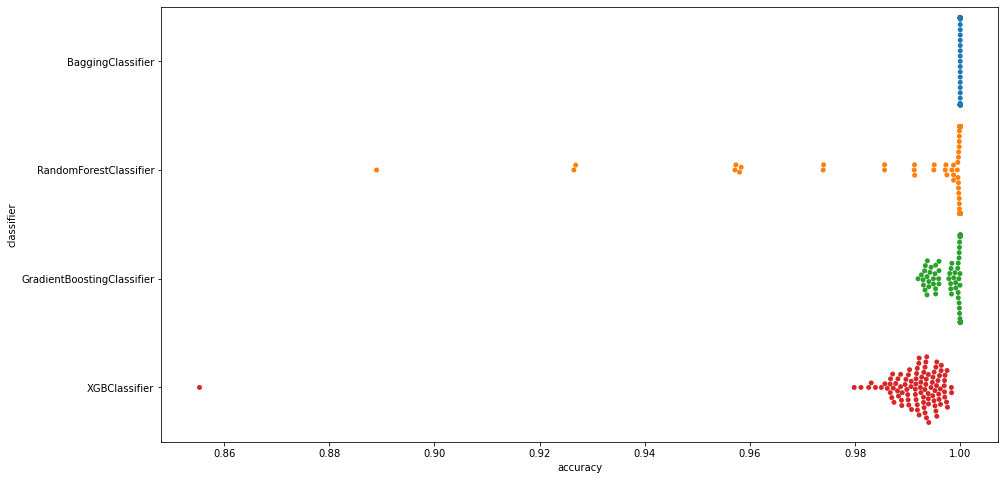

In [59]:
plt.figure(figsize=(15,8))
sns.swarmplot(data=trials_df, y='classifier', x='accuracy');

In [61]:
print("The best model " + top_models.iloc[0][0])
parameters=top_models.iloc[0][3]

keys = []
values = []
for key, value in parameters.items():
    keys.append(key)
    values.append(int(value[0]))
params = dict(zip(keys, values))

The best model GradientBoostingClassifier


In [62]:
pipe_finall = Pipeline(steps = [
    ('data_processing_pipeline', data_processing_pipeline),
    ('classifier', GradientBoostingClassifier(**params))
    ])


pipe_finall.fit(X_train, y_train)

Pipeline(steps=[('data_processing_pipeline',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('numerical_transformer',
                                                                   StandardScaler())]),
                                                  Index(['aluminium', 'ammonia', 'arsenic', 'barium', 'cadmium', 'chloramine',
       'chromium', 'copper', 'flouride', 'bacteria', 'viruses', 'lead',
       'nitrates', 'nitrites', 'mercury', 'perchlorate', 'radium', 'selenium',
       'silver', 'uranium'],
      dtype='object'))])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=13, n_estimators=445))])

In [63]:
data_processing_pipeline.transform(X_test)
y_pred = pipe_finall.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2125
         1.0       0.81      0.72      0.76       274

    accuracy                           0.95      2399
   macro avg       0.89      0.85      0.87      2399
weighted avg       0.95      0.95      0.95      2399



In [65]:
print(accuracy_score(y_test,y_pred))

0.948728636932055


AxesSubplot(0.125,0.125;0.62x0.755)


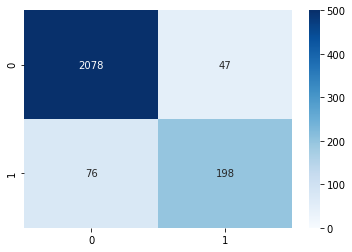

In [66]:
print(sns.heatmap(confusion_matrix(y_test,y_pred),vmin=0,vmax=500,annot=True,cmap='Blues',fmt='g'));